In [1]:

import mlflow
from mlflow.tracking import MlflowClient

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itables import show
import plotly.express as px

from developability import data as data_
from developability.utils import ls
from developability.mlflow_tools import *
from tqdm.notebook import tqdm

## retina display
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

%load_ext autoreload
%autoreload 2

# paths 

data_path = Path(data_.__path__[0])

### Load Data 

In [2]:
data_path = Path(data_.__path__[0])
training_path = data_path / 'train'
data = pd.read_parquet(training_path/'Therapeutic_and_internal_antibodies.parquet')
data.head()

HeparinRRT      Project  HCDR1_APBS_pos  HCDR1_APBS_neg  \
antibody                                                               
adalimumab         0.79  Therapeutic      361.422343     -794.503791   
daclizumab         0.84  Therapeutic     4252.553904        0.000000   
ganitumab          0.79  Therapeutic     1818.147090        0.000000   
vedolizumab        0.54  Therapeutic        0.000000    -2649.100853   
natalizumab        0.54  Therapeutic      972.583337      -97.200479   

             HCDR1_APBS_net  HCDR2_APBS_pos  HCDR2_APBS_neg  HCDR2_APBS_net  \
antibody                                                                      
adalimumab      -433.081449     1555.624126    -4014.715450    -2459.091324   
daclizumab      4252.553904     4452.876492     -904.794295     3548.082197   
ganitumab       1818.147090     6910.914448        0.000000     6910.914448   
vedolizumab    -2649.100853     4492.540426    -5860.854936    -1368.314511   
natalizumab      875.382858    11200.435647     -312.532150    10887.903497   

             HCDR3_APBS_pos  HCDR3_APBS_neg  HCDR3_APBS_net  HFR1_APBS_pos  \
antibody                                                                     
adalimumab      2875.086488     -138.003294     2737.083194    5376.458039   
daclizumab      3911.936888        0.000000     3911.936888   14311.015341   
ganitumab       2961.303964     -484.904947     2476.399018   10333.605343   
vedolizumab        0.000000    -6989.631169    -6989.631169    6391.205916   
natalizumab     5410.511420        0.000000     5410.511420   16469.362126   

             HFR1_APBS_neg  HFR1_APBS_net  HFR2_APBS_pos  HFR2_APBS_neg  \
antibody                                                                  
adalimumab    -1771.257720    3605.200319    2726.475633    -584.411432   
daclizumab     -193.586163   14117.429178    1868.888108     -38.688851   
ganitumab      -525.798048    9807.807295    2872.797423    -281.600949   
vedolizumab    -986.398297    5404.807619    3360.681228       0.000000   
natalizumab    -162.325666   16307.036460    5172.353262       0.000000   

             HFR2_APBS_net  HFR3_APBS_pos  HFR3_APBS_neg  HFR3_APBS_net  \
antibody                                                                  
adalimumab     2142.064200    3398.963679   -1368.871898    2030.091781   
daclizumab     1830.199256    4672.451210    -414.558541    4257.892669   
ganitumab      2591.196475   11761.616999    -147.382398   11614.234601   
vedolizumab    3360.681228    3163.553567   -2239.208472     924.345095   
natalizumab    5172.353262    7039.283850    -181.734569    6857.549282   

             HFR4_APBS_pos  HFR4_APBS_neg  HFR4_APBS_net  LCDR1_APBS_pos  \
antibody                                                                   
adalimumab      905.524940    -973.487817     -67.962877     7088.950311   
daclizumab     1996.455362    -125.736264    1870.719098     2912.056050   
ganitumab       360.371905   -1259.033101    -898.661196     4405.906664   
vedolizumab     306.504321   -1241.789054    -935.284733     3087.786259   
natalizumab    2097.229021    -182.749645    1914.479376     4184.768499   

             LCDR1_APBS_neg  LCDR1_APBS_net  LCDR2_APBS_pos  LCDR2_APBS_neg  \
antibody                                                                      
adalimumab        -2.623292     7086.327019     1842.767512        0.000000   
daclizumab      -214.503158     2697.552891     2848.982419        0.000000   
ganitumab       -170.769361     4235.137303     2334.634695        0.000000   
vedolizumab     -636.602461     2451.183798      509.924516    -1506.710115   
natalizumab     -140.461723     4044.306775     2837.599448        0.000000   

             LCDR2_APBS_net  LCDR3_APBS_pos  LCDR3_APBS_neg  LCDR3_APBS_net  \
antibody                                                                      
adalimumab      1842.767512     3232.607354      -34.553594     3198.053760   
daclizumab      2848.982419    

### Connect to client and list experiments

In [3]:
client = MlflowClient(tracking_uri = 'http://127.0.0.1:5000')
exps = client.search_experiments()

def keep(name): 
    words = ['Normalization', 'PCA', 'Conditional']
    for word in words: 
        if word in name:
            return True
    return False

# list the name of desired experiments. 
experiments = {}
for i, exp in enumerate(exps):
    if keep(exp.name):
        df = runs_to_dataframe(client.search_runs(experiment_ids = exp.experiment_id))
        df.insert(0, 'experiment_name', exp.name)
        experiments[exp.name] = df
        print(i, exp.experiment_id,'\t',  exp.name)
        

0 774817144151895142 	 RegressionWithRowNormalization1
1 968210472893656467 	 RegressionWithPCA1
2 163746521336102013 	 RegressionWithConditionalInterceptAndSlope1
3 379577206985480093 	 RegressionWithConditionalIntercept1


### Plot cross validation data for each experiment. 

##### Regression with conditional Intercept 1 


In [4]:
def clean_columns(df): 
    return df.rename(columns ={col:col.split('.')[-1] for col in df.columns})

def extract_exp_type(s): 
    if 'row' in s.lower(): 
        return 'Normalization'
    elif 'pca' in s.lower(): 
        return 'PCA'
    elif 'conditional' in s.lower() and 'slope' in s.lower():
        return 'Conditional intercept/slope'
    elif 'conditional' in s.lower():
        return 'Conditional intercept'
    else: 
        return 'Unknown'
    

In [5]:
metadata = pd.concat(list(experiments.values())).reset_index(drop=True)
metadata['tags.feature_set'] = metadata['tags.feature_set'].str.replace('postive_cdr', 'positive_cdr')

metadata['Project'] = metadata['tags.Description'].str.split(' ').str.get(-1).str.replace('.', '')
metadata['Experiment Type'] = metadata['tags.Description'].apply(extract_exp_type)


prefixes = ['Experiment', 'Project', 'tags.model', 'tags.feature_set', 'metrics']
metadata2 = clean_columns(get_columns(metadata, prefixes = prefixes, exclude = ['sem', 'mean']))

show(metadata2)

### Plot R2 Versus RMSE for Test CV. 

Below I plot the R2 versus the RMSE. This is evaluated using 10x Repeated 5 Fold CV. We see a very relationship between the two values for different feature processing methods (experiment Type) and projects. Note that we see the best RMSE (lowest) when therapeutics are held out but reduced R2. So the therapeutic antibodies increase diversity allowing the model to explain the variance but are also harder to classify.

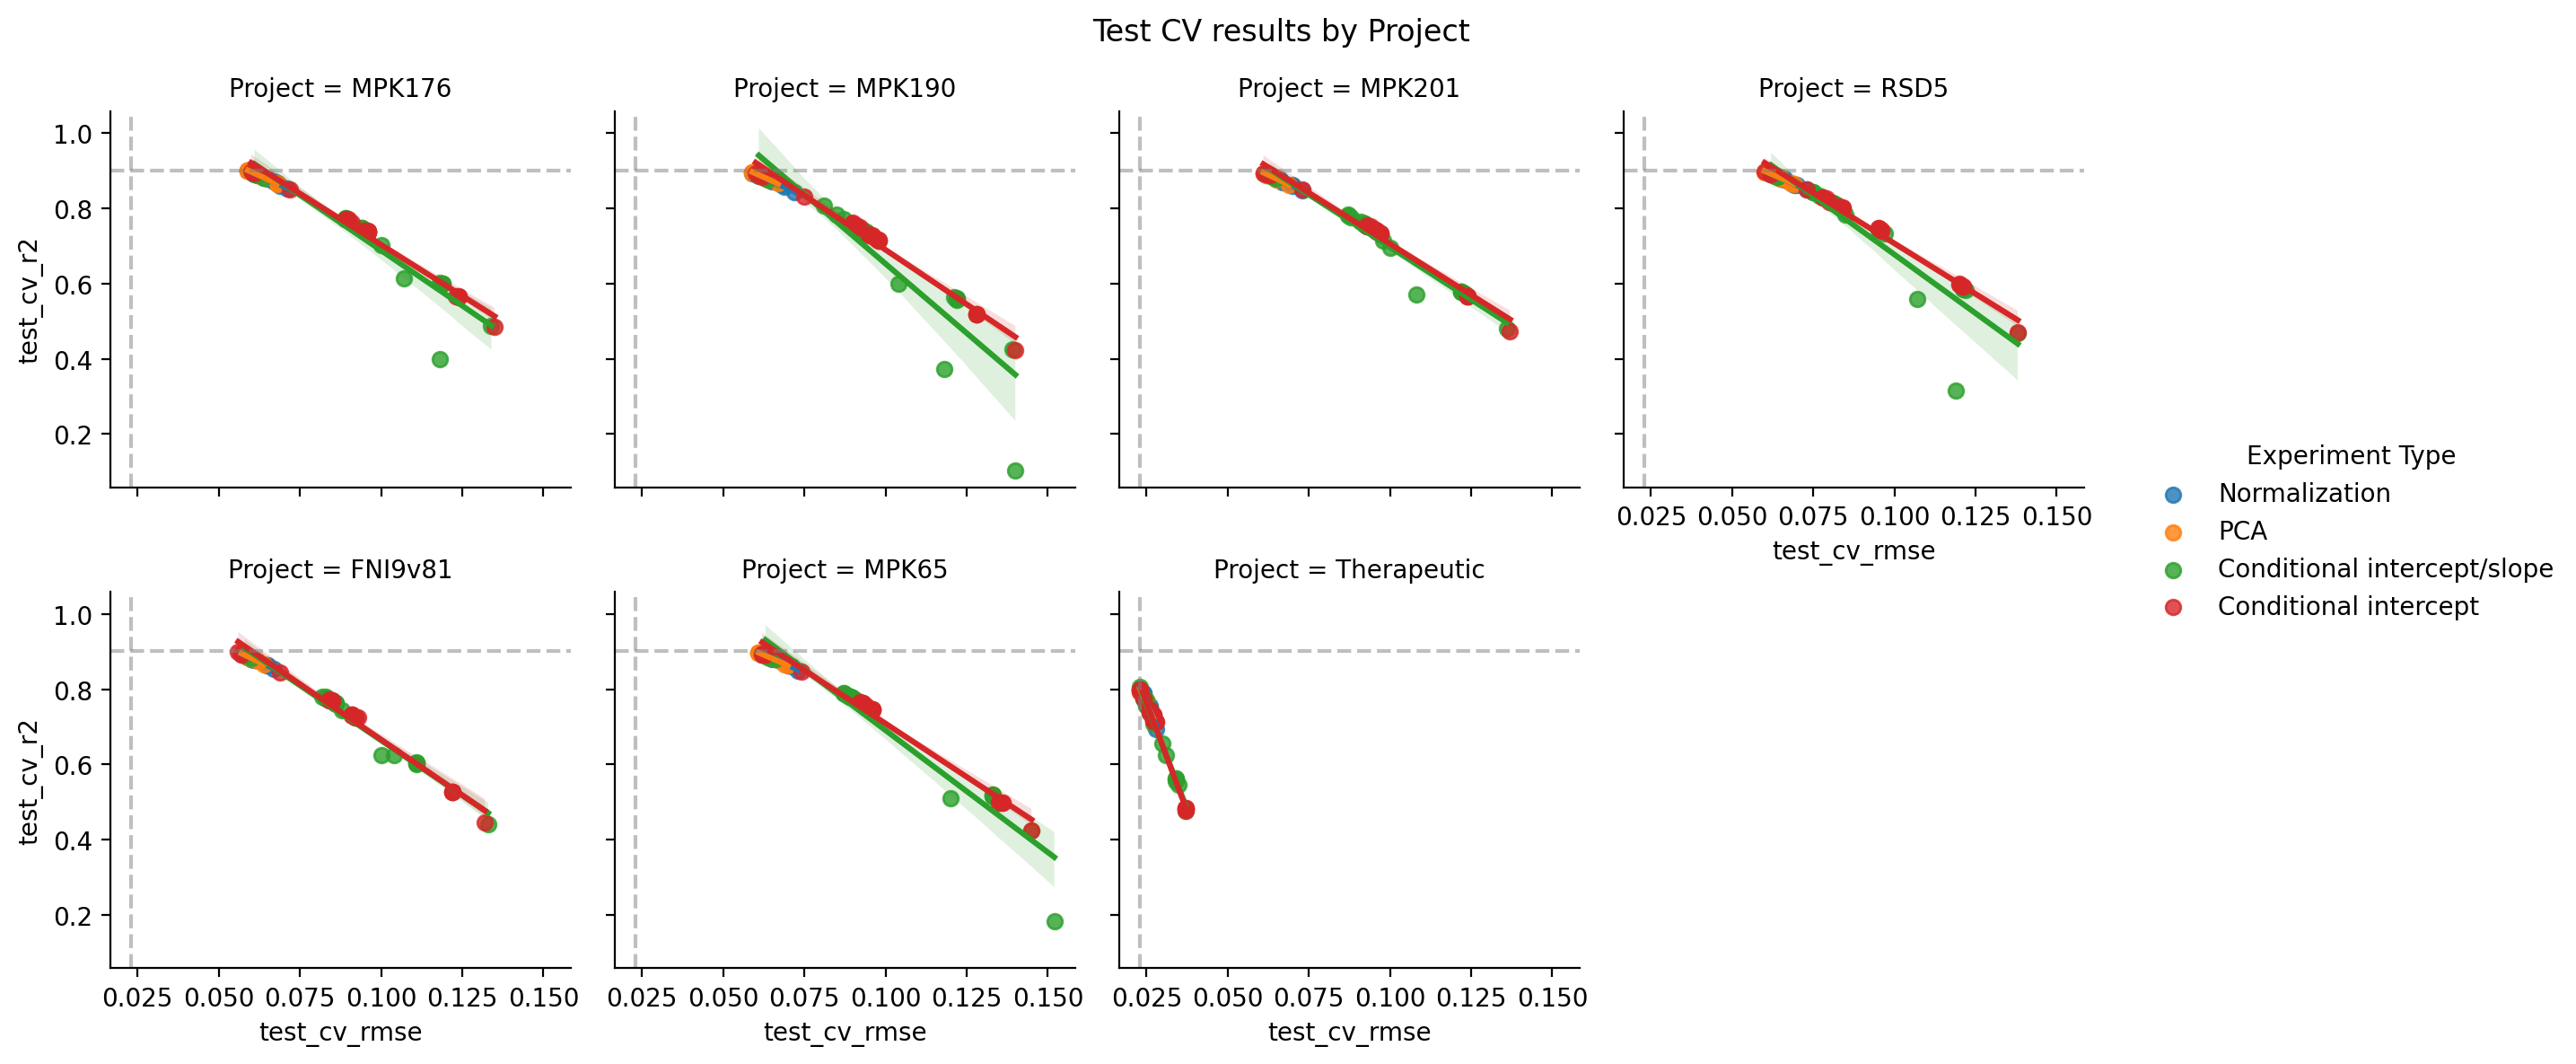

In [6]:
min_rmse=metadata2['test_cv_rmse'].min()
max_r2=metadata2['test_cv_r2'].max()
g = sns.lmplot(data = metadata2, y= 'test_cv_r2', x='test_cv_rmse', hue ='Experiment Type', col = 'Project', col_wrap=4, height=3)
for ax in g.axes.flat: 
    ax.axvline(min_rmse, color = 'grey', linestyle = '--', alpha = 0.5)
    ax.axhline(max_r2, color = 'grey', linestyle = '--', alpha =0.5)

plt.gcf().suptitle('Test CV results by Project')
g.tight_layout()

### Plot boxplots to determine how the different model parameters effect RMSE and R2. 

The parameters I explore are experiment type (feature preprocessing), feature_set (which features) and model type. 

##### Experiment Type

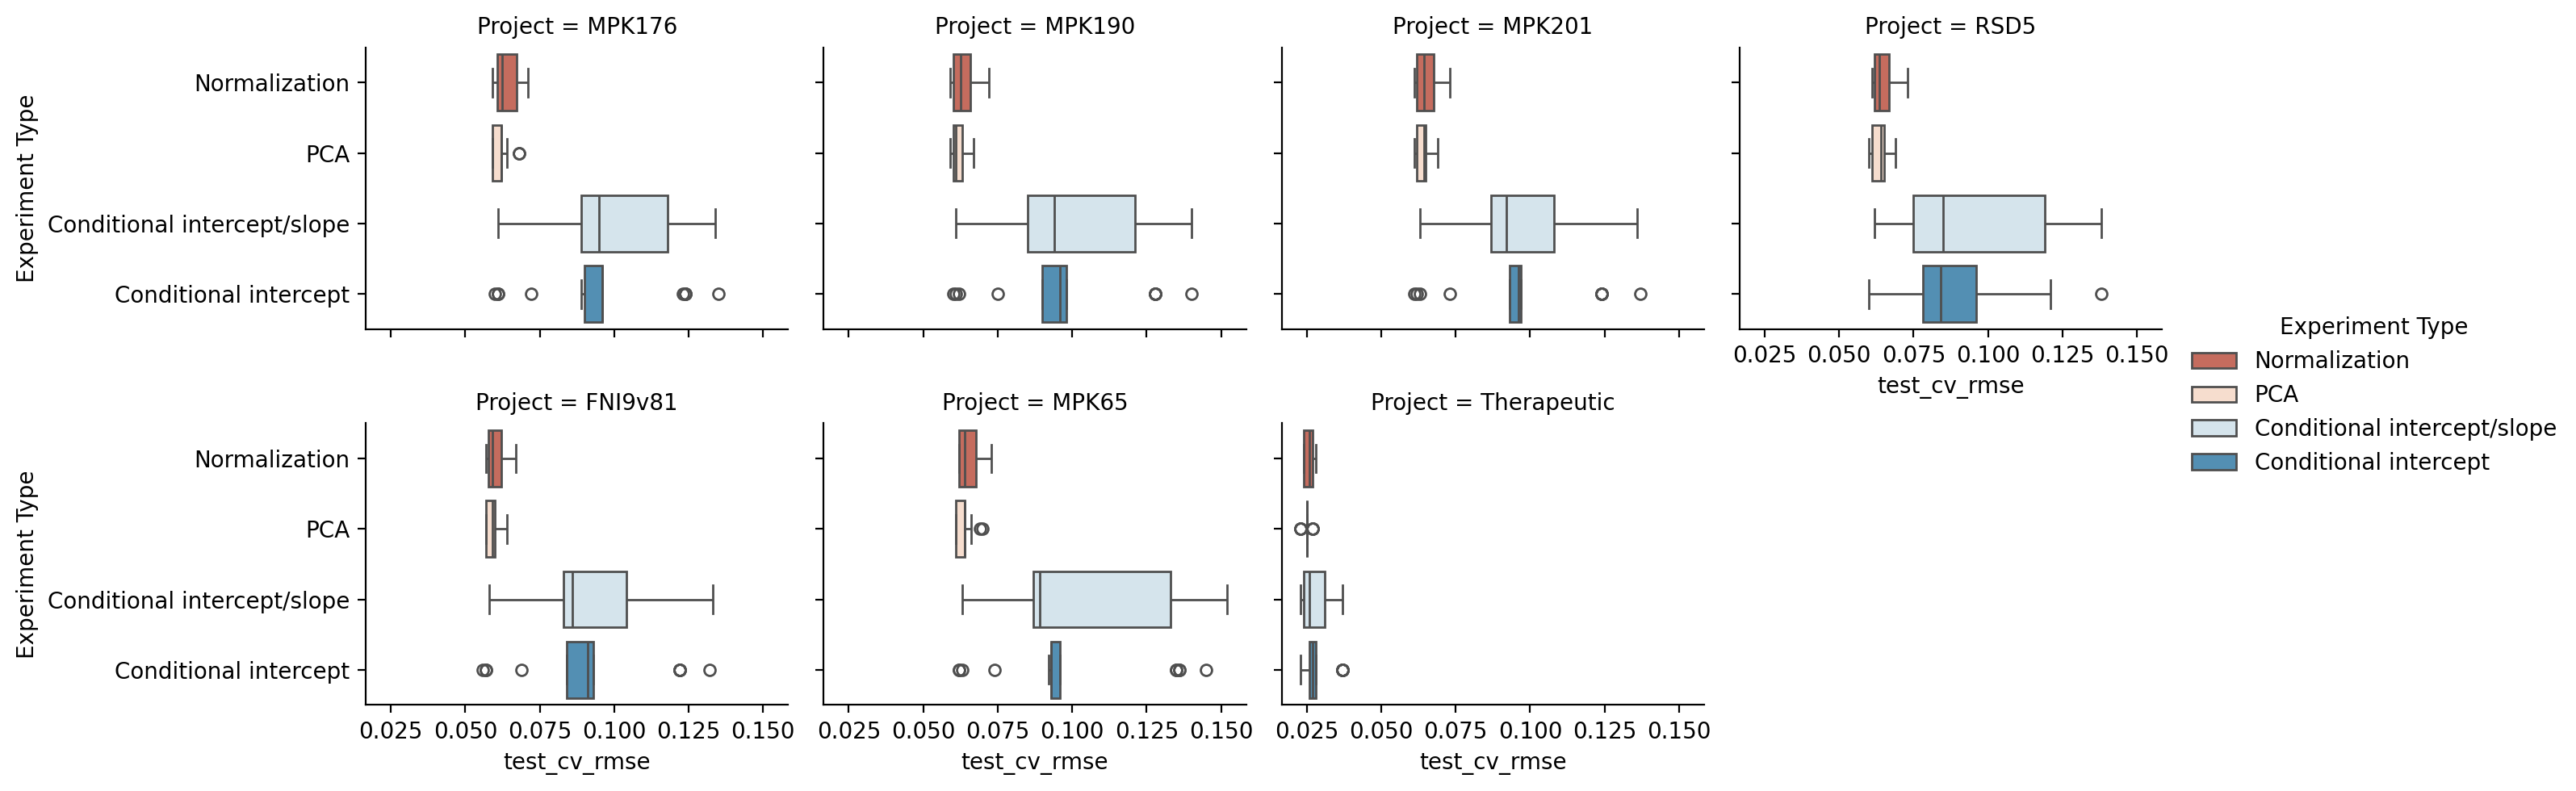

In [7]:
y= 'Experiment Type'
x ='test_cv_rmse' 
h=2.5
aspect = 1.4
g= sns.catplot(data=metadata2, kind = 'box', x=x,y=y, hue=y, palette='RdBu', col ='Project',col_wrap = 4, 
               height = h, aspect = aspect, legend=True)

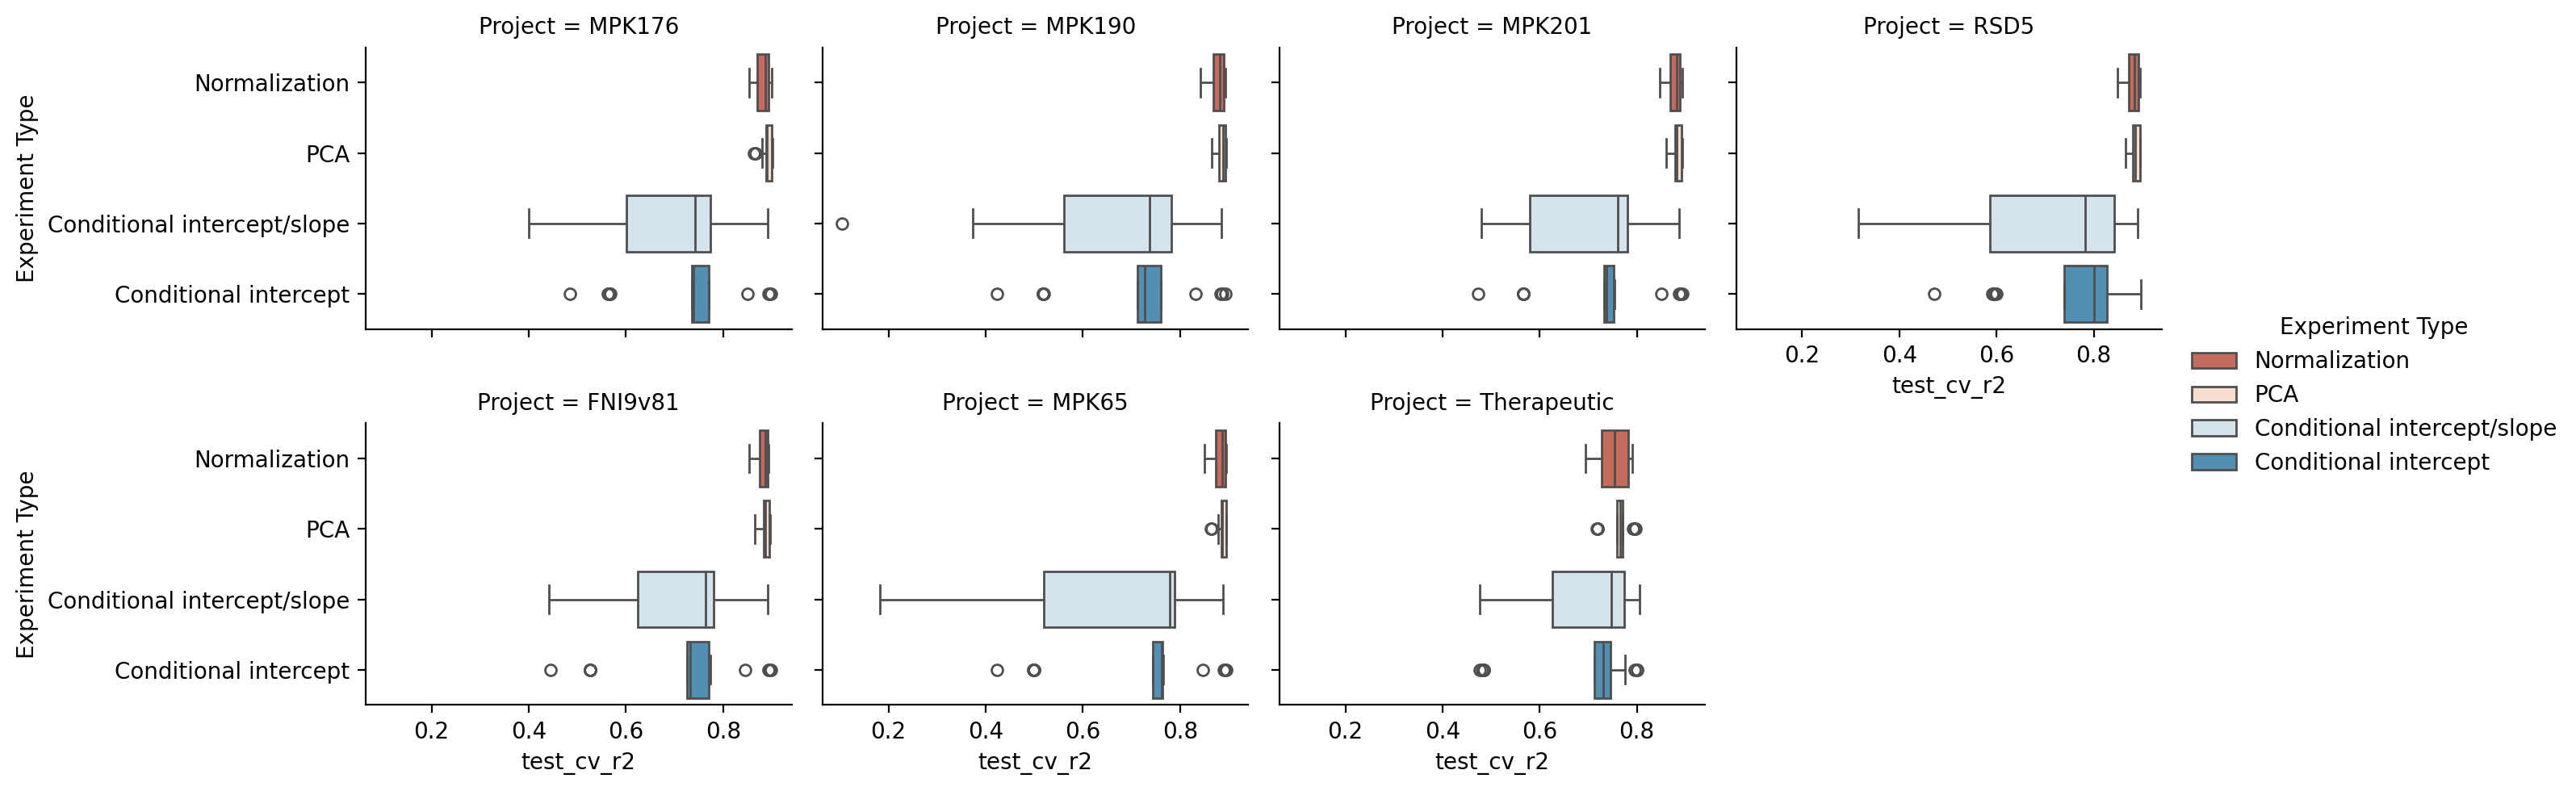

In [8]:
y= 'Experiment Type'
x ='test_cv_r2' 
h=2.5
aspect = 1.4
g= sns.catplot(data=metadata2, kind = 'box',x=x, y=y, hue=y, palette='RdBu', col ='Project',col_wrap = 4, 
               height = h, aspect = aspect, legend=True)

##### Feature Set

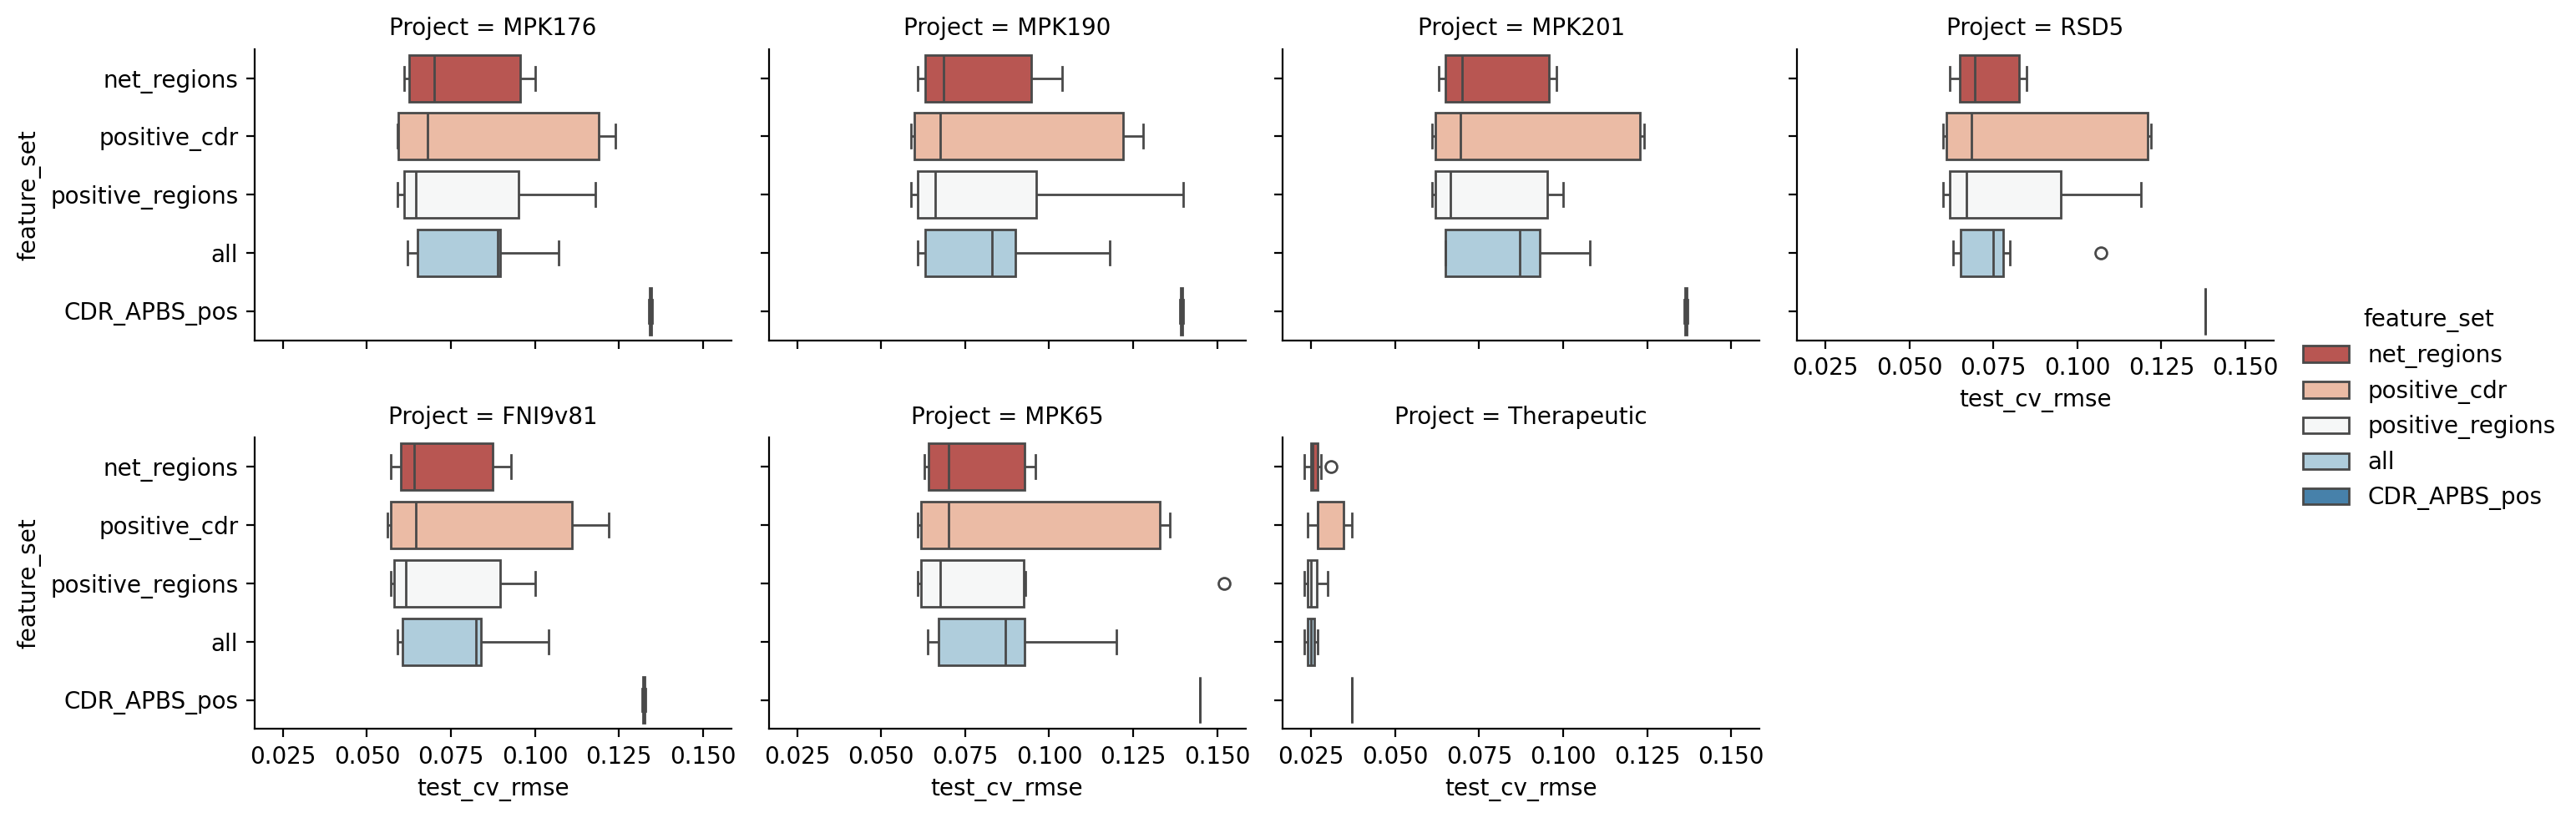

In [9]:
y= 'feature_set'
x ='test_cv_rmse' 
h=2.5
aspect = 1.4
g= sns.catplot(data=metadata2, kind = 'box', x=x, y=y, hue=y, palette='RdBu', col ='Project',col_wrap = 4, 
               height = h, aspect = aspect, legend=True)

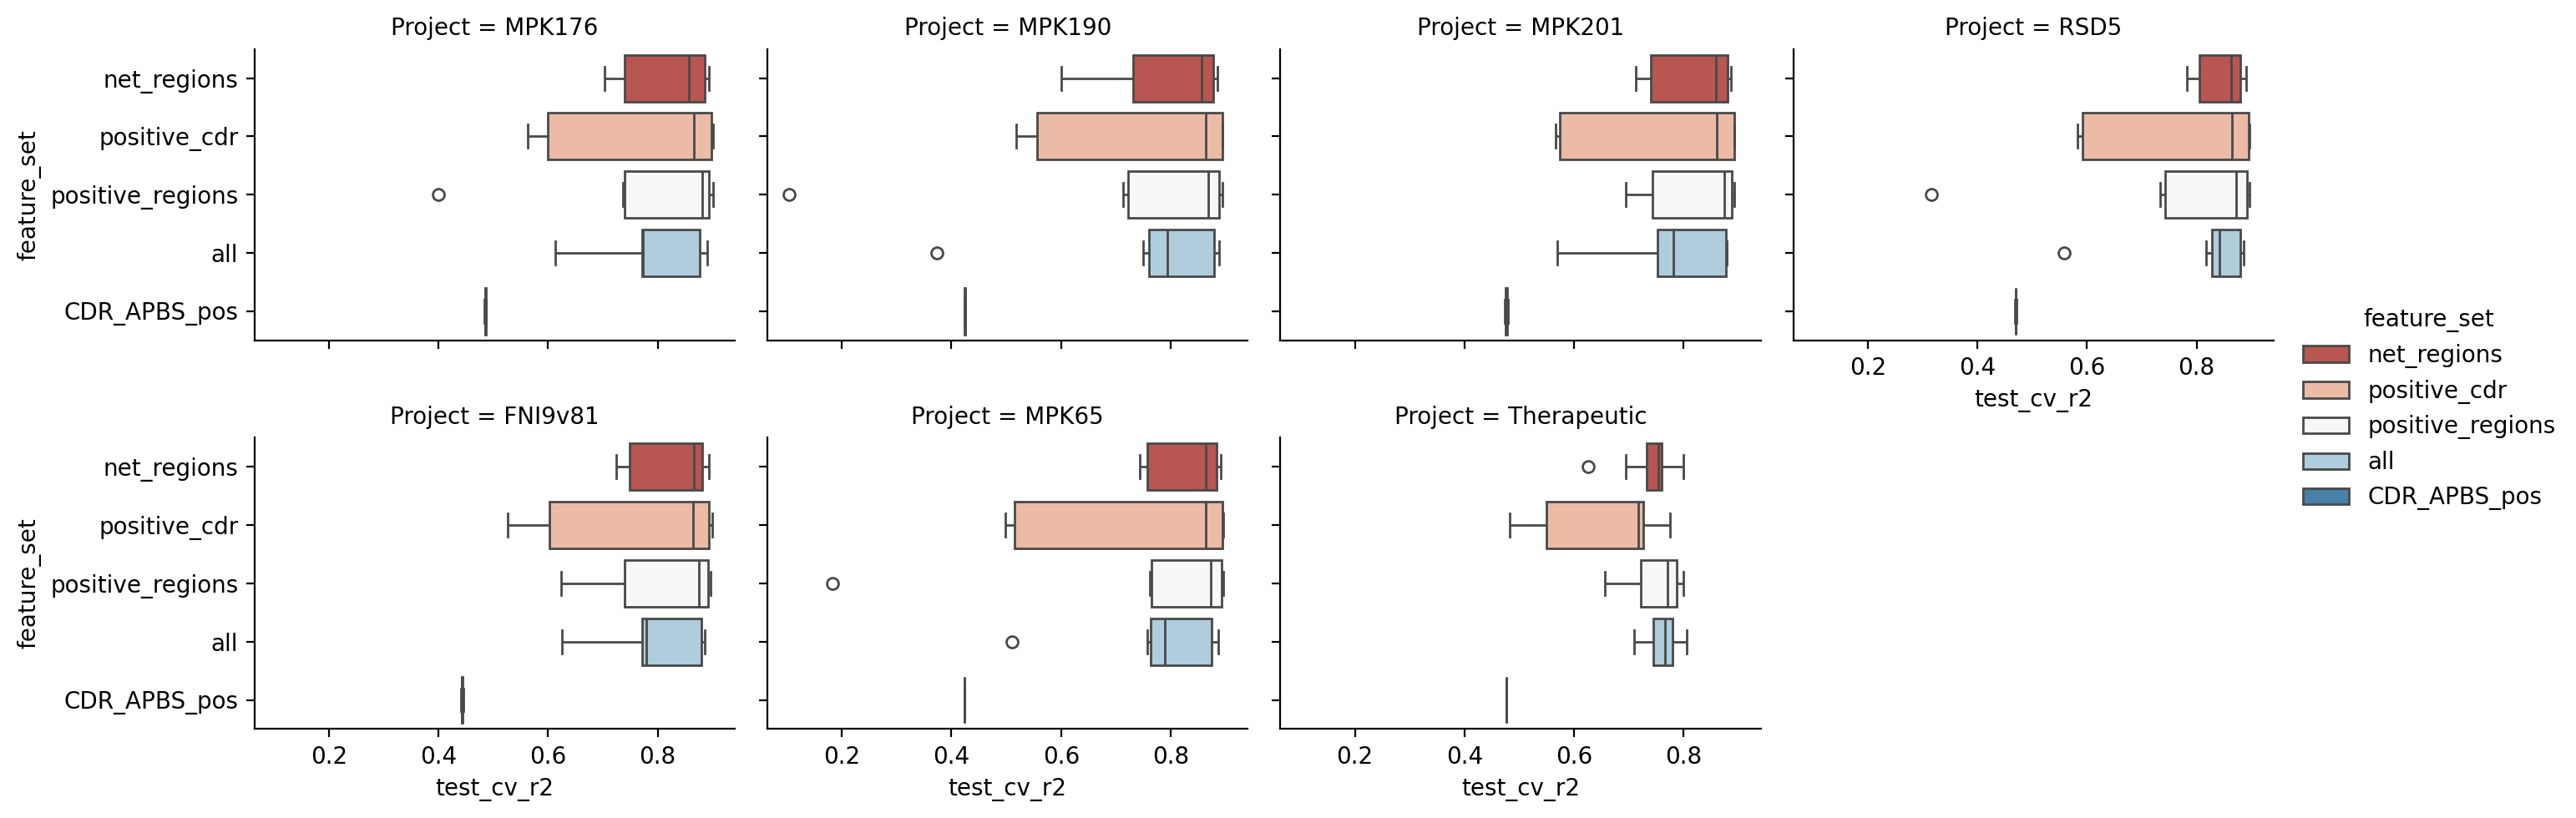

In [10]:
y= 'feature_set'
x ='test_cv_r2' 
h=2.5
aspect = 1.4
g= sns.catplot(data=metadata2, kind = 'box', x=x, y=y, hue=y, palette='RdBu', col ='Project',col_wrap = 4, 
               height = h, aspect = aspect, legend=True)

##### Model Type

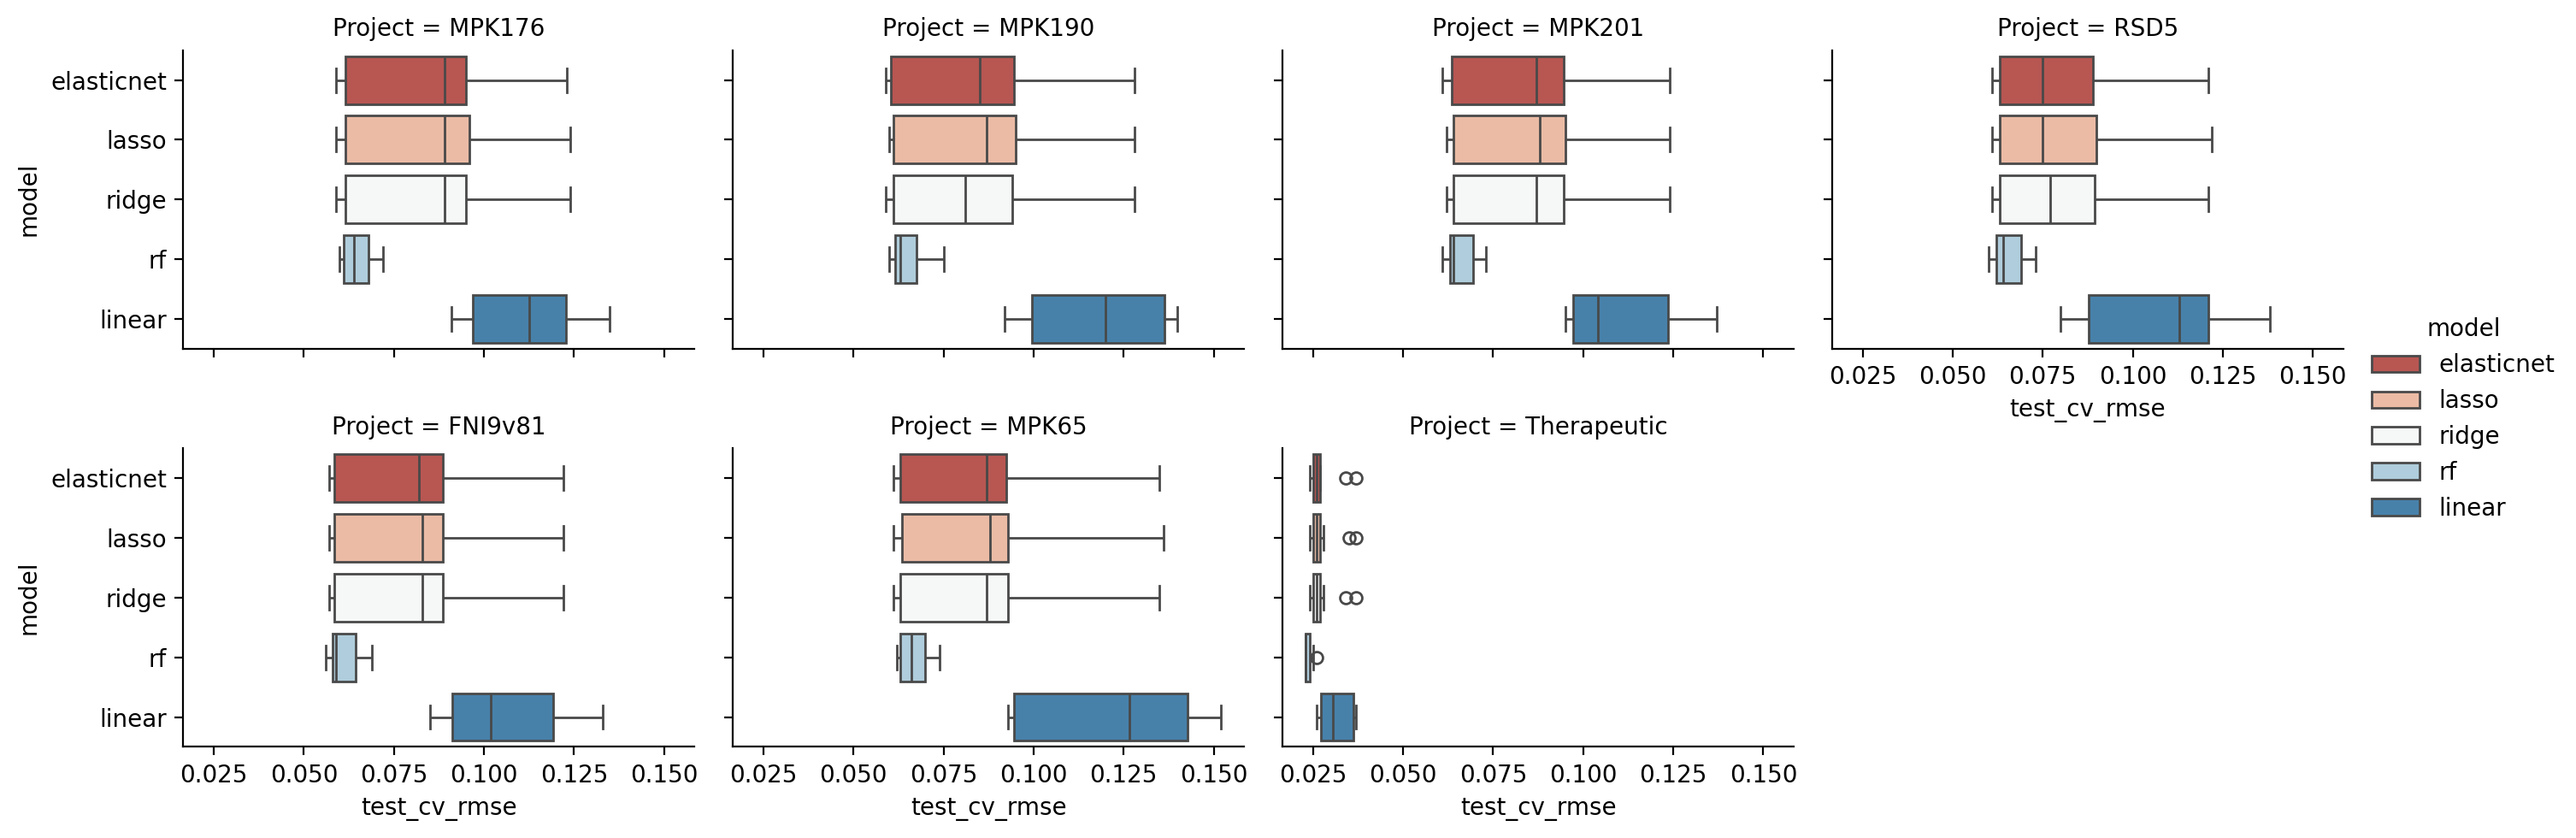

In [11]:
y= 'model'
x ='test_cv_rmse' 
h=2.5
aspect = 1.4
g= sns.catplot(data=metadata2, kind = 'box', x=x, y=y, hue=y, palette='RdBu', col ='Project',col_wrap = 4, 
               height = h, aspect = aspect, legend=True)

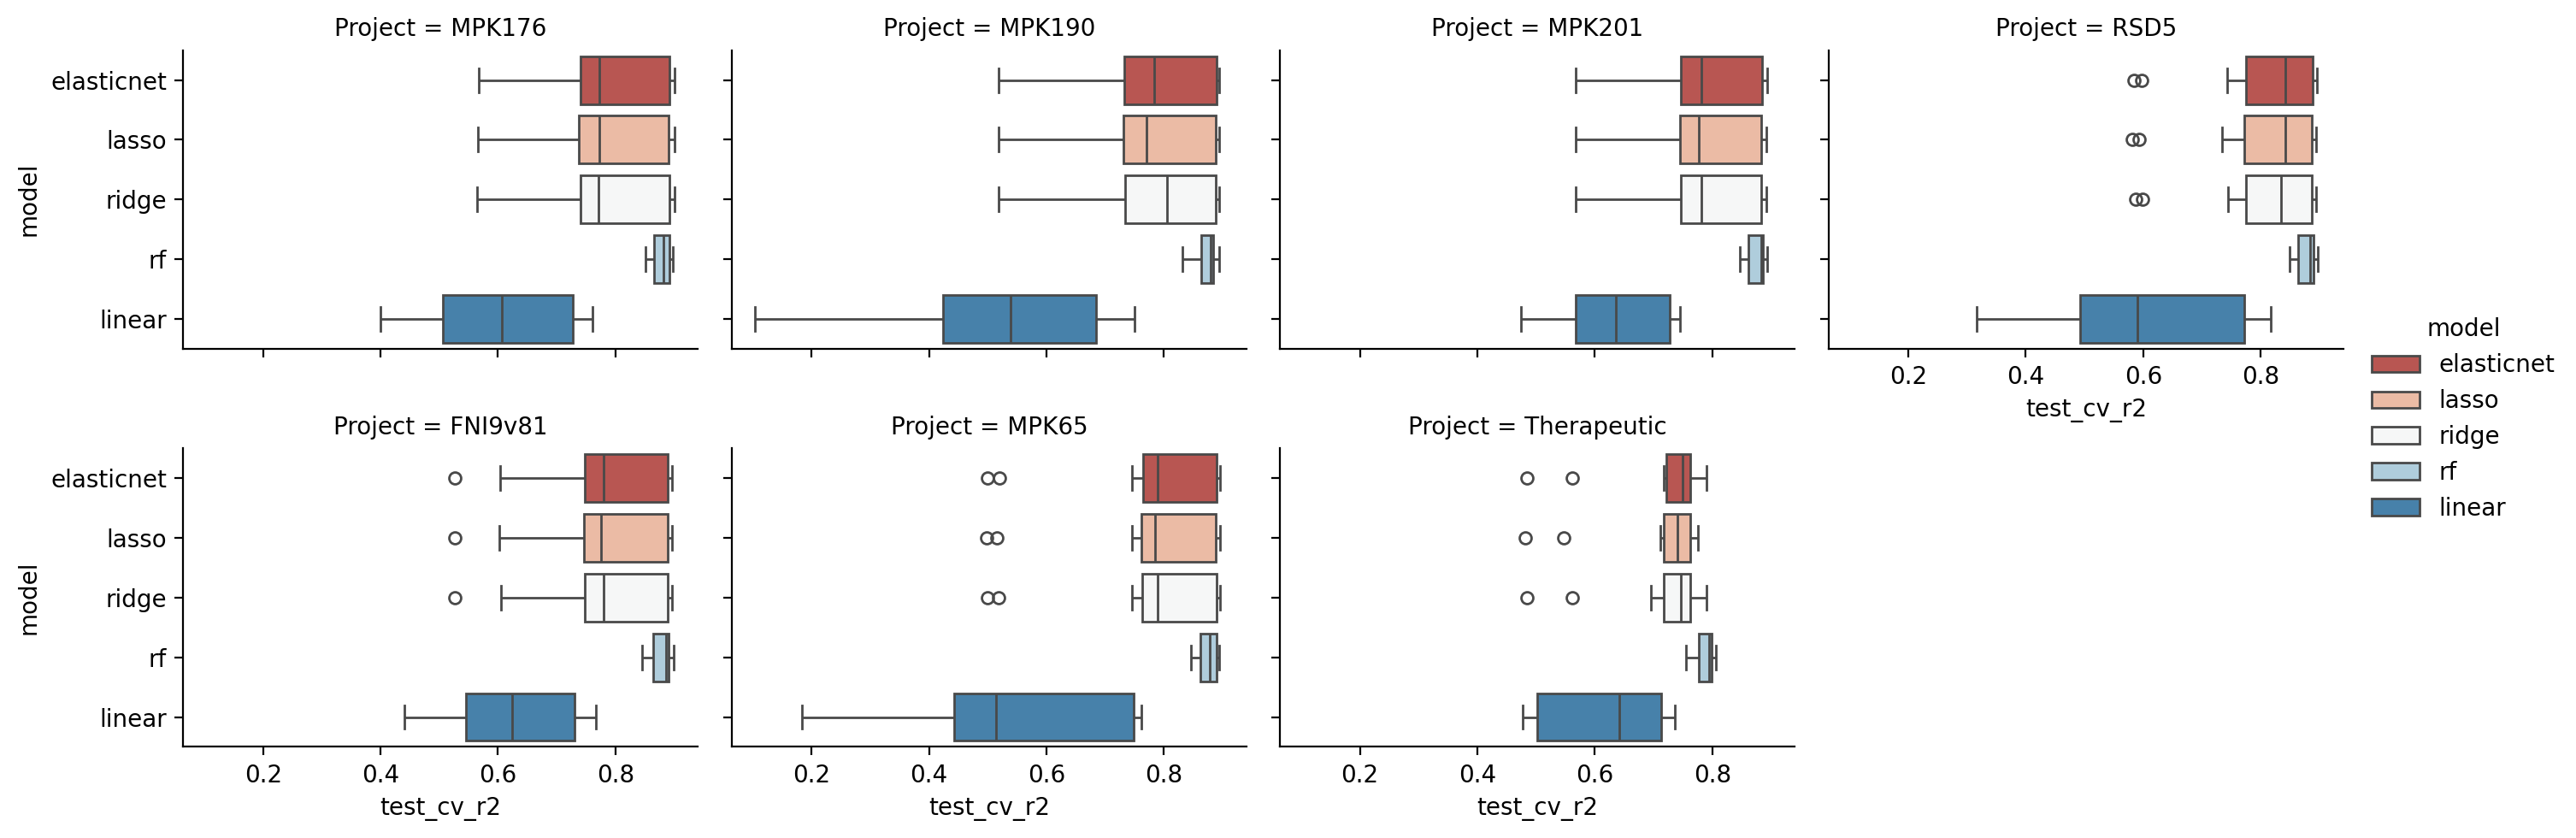

In [12]:
y= 'model'
x ='test_cv_r2' 
h=2.5
aspect = 1.4
g= sns.catplot(data=metadata2, kind = 'box', x=x, y=y, hue=y, palette='RdBu', col ='Project',col_wrap = 4, 
               height = h, aspect = aspect, legend=True)

##### Project
We plot this differently. 

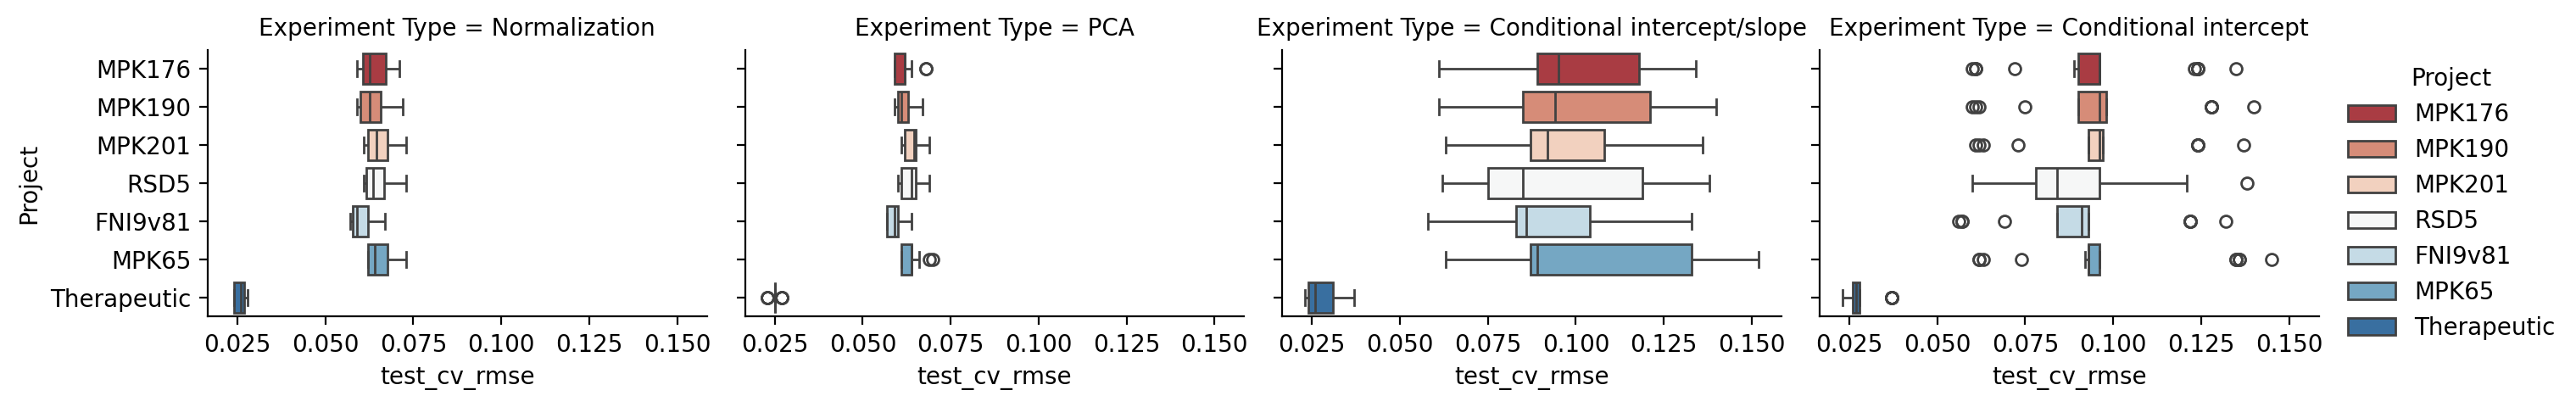

In [13]:
y= 'Project'
x ='test_cv_rmse' 
col = 'Experiment Type'
h=2.5
aspect = 1.4
g= sns.catplot(data=metadata2, kind = 'box', x=x, y=y, hue=y, palette='RdBu', col =col, col_wrap = 4, 
               height = h, aspect = aspect, legend=True)

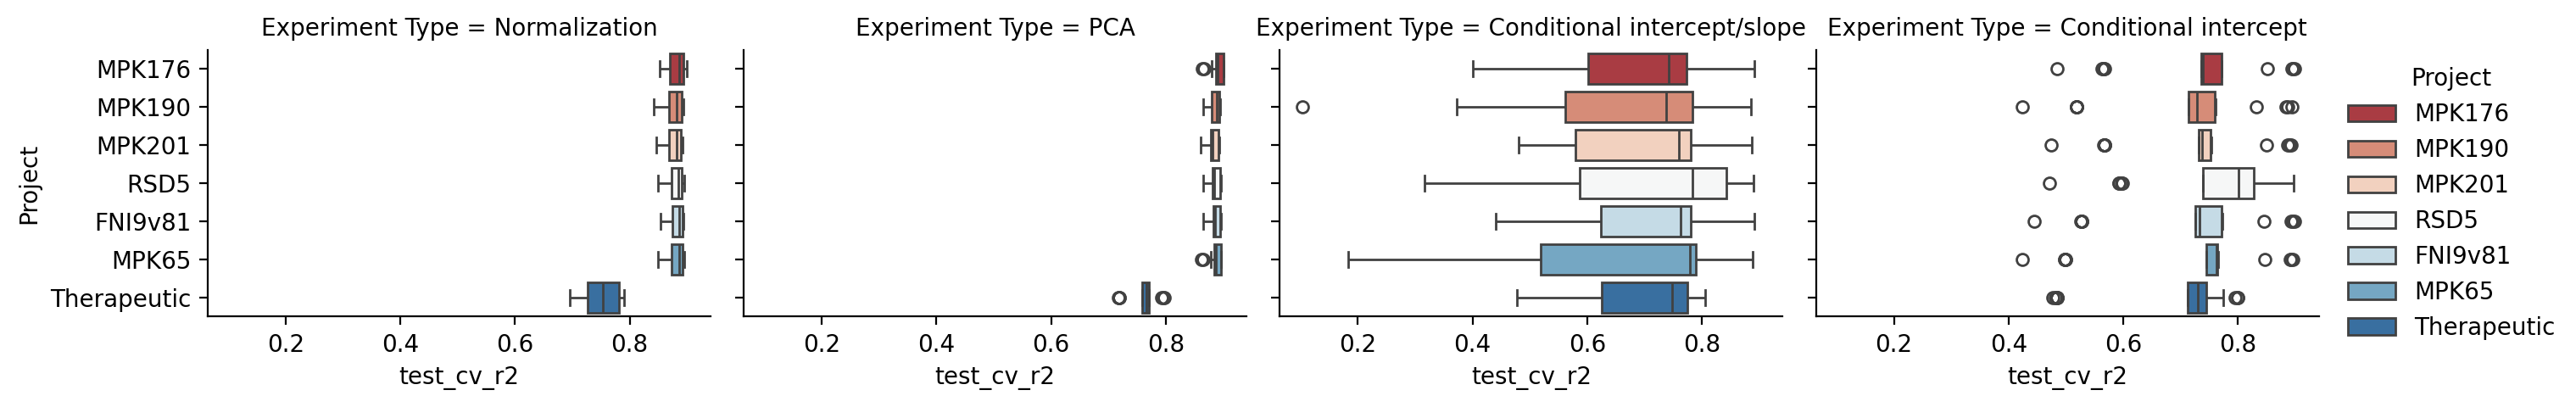

In [14]:
y= 'Project'
x ='test_cv_r2' 
col = 'Experiment Type'
h=2.5
aspect = 1.4
g= sns.catplot(data=metadata2, kind = 'box', x=x, y=y, hue=y, palette='RdBu', col =col, col_wrap = 4, 
               height = h, aspect = aspect, legend=True)

#### Comments: 
From the boxplots above we can make the following conclusions. 
As seen above, performance is affected by the: 
1. The project/dataset not included in training. For the most part, excluding all the internal datasets appears to have minimal effects on the performance. However, removing the Therapeutic antibodies reduces R2 (bad) and reduced RMSE (good). Overall, it would seem that including them is good. Would be better if had the same inhouse scaling. 
2. Experiment Type (feature preprocessing). Either performing PCA or doing Normalization leads to a large improvement in performance. In truth, I also included one-hot-encoding in these. I assume that helps. Consider doing the experiment with no one-hot encoding. Adding a conditional slope hurts. 
3. Feature set. For the most part it seems Positive regions>= CDR pos>=All>total cdr pos.
4. Model type. Overall RF does the overall best, with Lasso, elasticnet, and ridge being roughly the same. However the linear model does the worse by R2 and RMSE. 


### Now calculate results on heldout set. 




##### Functions for plottging and loading models 

In [38]:
def get_model_from_row(index): 
    
    df = metadata
    row = df.loc[index]
    print(row.Project)
    uri = row.artifact_uri.replace('mlflow-artifacts:/' ,'')
    model_name = row['tags.model']
    path = Path('/home/crivera/projects/developability/mlartifacts')/uri/model_name
    model = mlflow.sklearn.load_model(path)
    return model


def predict(project, model):
    projects = data['Project'].unique()
    
    df = (data.copy()
          .query('Project==@project')
          )

    preds = []
    trained_projects= [proj for proj in projects if proj!=project]
    for proj in trained_projects: 
            df['Project']=proj
            preds.append(pd.Series(model.predict(df)))
    
    preds = pd.concat(preds, axis = 1)
    preds.index = df.index
    preds.columns = trained_projects
    preds['mean_Y_Pred'] = preds.mean(axis = 1)
    preds['SD'] = preds.std(axis = 1)
    preds['Y_True'] = df['HeparinRRT']
    return preds


def wide_to_long_preds(df): 
    dfs = []
    for col in df.columns[:5].tolist() + ['mean_Y_Pred']:
        col_df = df[[col]].melt(var_name='Project', value_name='Y_Pred')
        col_df['Y_True'] = df['Y_True'].values
        dfs.append(col_df)
    
    return pd.concat(dfs)


def plot_predictions(index, height=3, aspect = 1):
    
    model =get_model_from_row(index)
    
    row  = metadata.loc[index]
    
    project = row['Project']
    model_name = row['tags.model']
    feature_set = row['tags.feature_set']
    
    experiment_type = row['Experiment Type']
    

    preds = wide_to_long_preds(predict(project, model))
    g = sns.lmplot(data=preds, x='Y_True',y='Y_Pred', col = 'Project',hue='Project', legend=False, facet_kws=dict(sharex=False, sharey=False), height = height, aspect = aspect)
    fig = plt.gcf()
    fig.suptitle(f'Scatter plot of predictions for {model_name} trained on {feature_set} with {experiment_type} featurization,  {project} held out.')
    g.tight_layout()
    

#### Select the best 5 models by R2. 

In [39]:
n = 1
best_model_by_project_no_rf = (metadata2.query('model!="rf"')
                               .sort_values(['test_cv_rmse', 'test_cv_r2'], ascending = [True, False])
                               .groupby('Project')
                               .head(n)
                               .reset_index()
                               )
show(best_model_by_project_no_rf, index =True)




#### Plot the models. 

Therapeutic


FNI9v81
MPK176
MPK190
RSD5
MPK65
MPK201


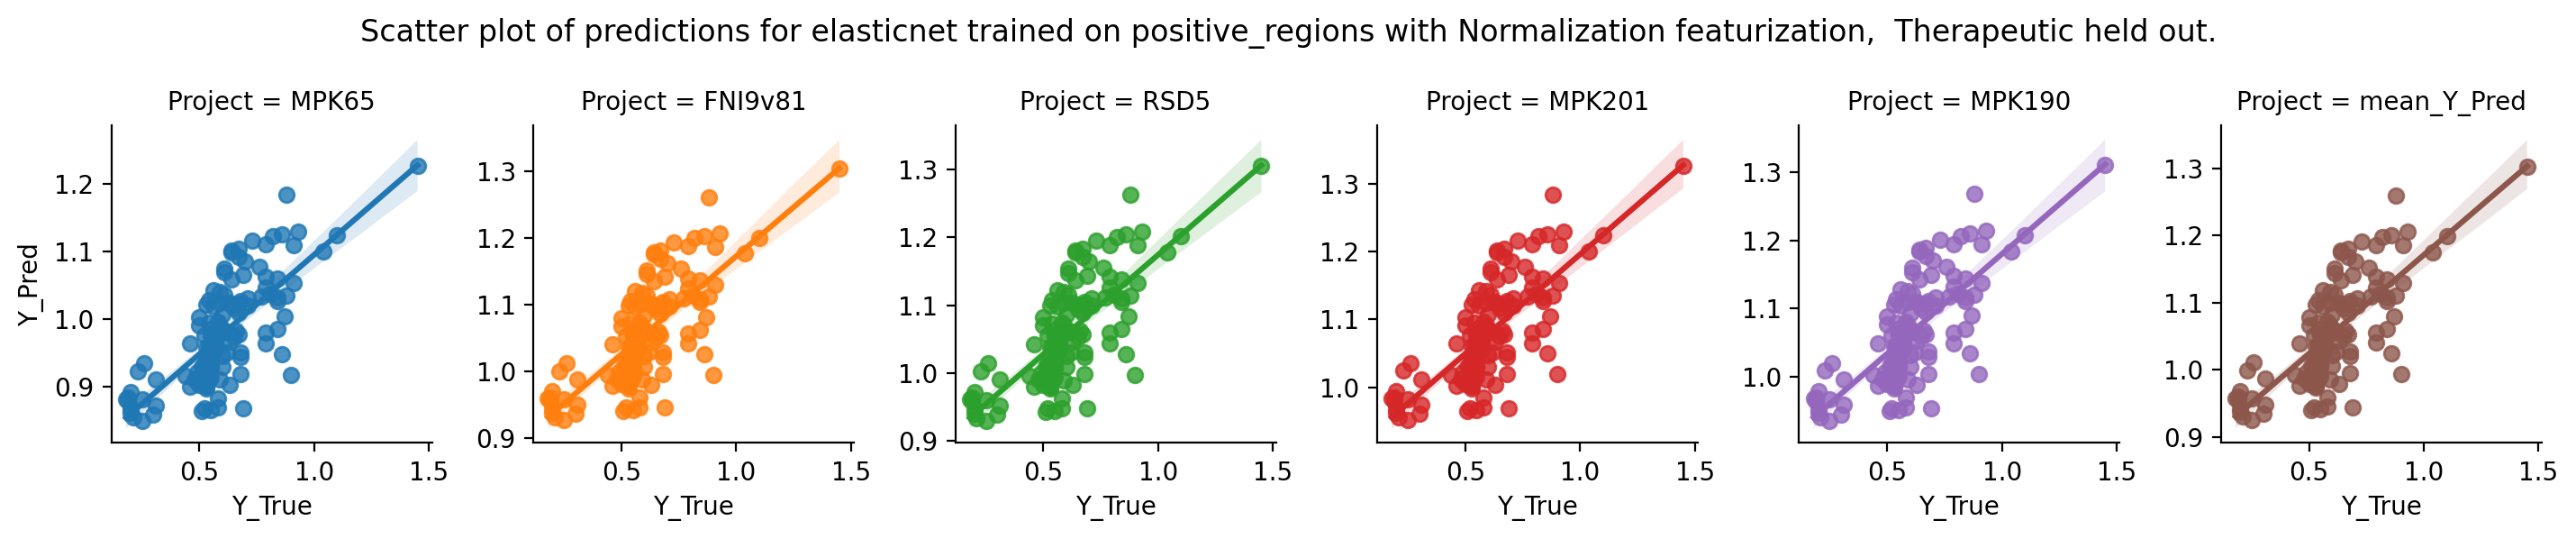

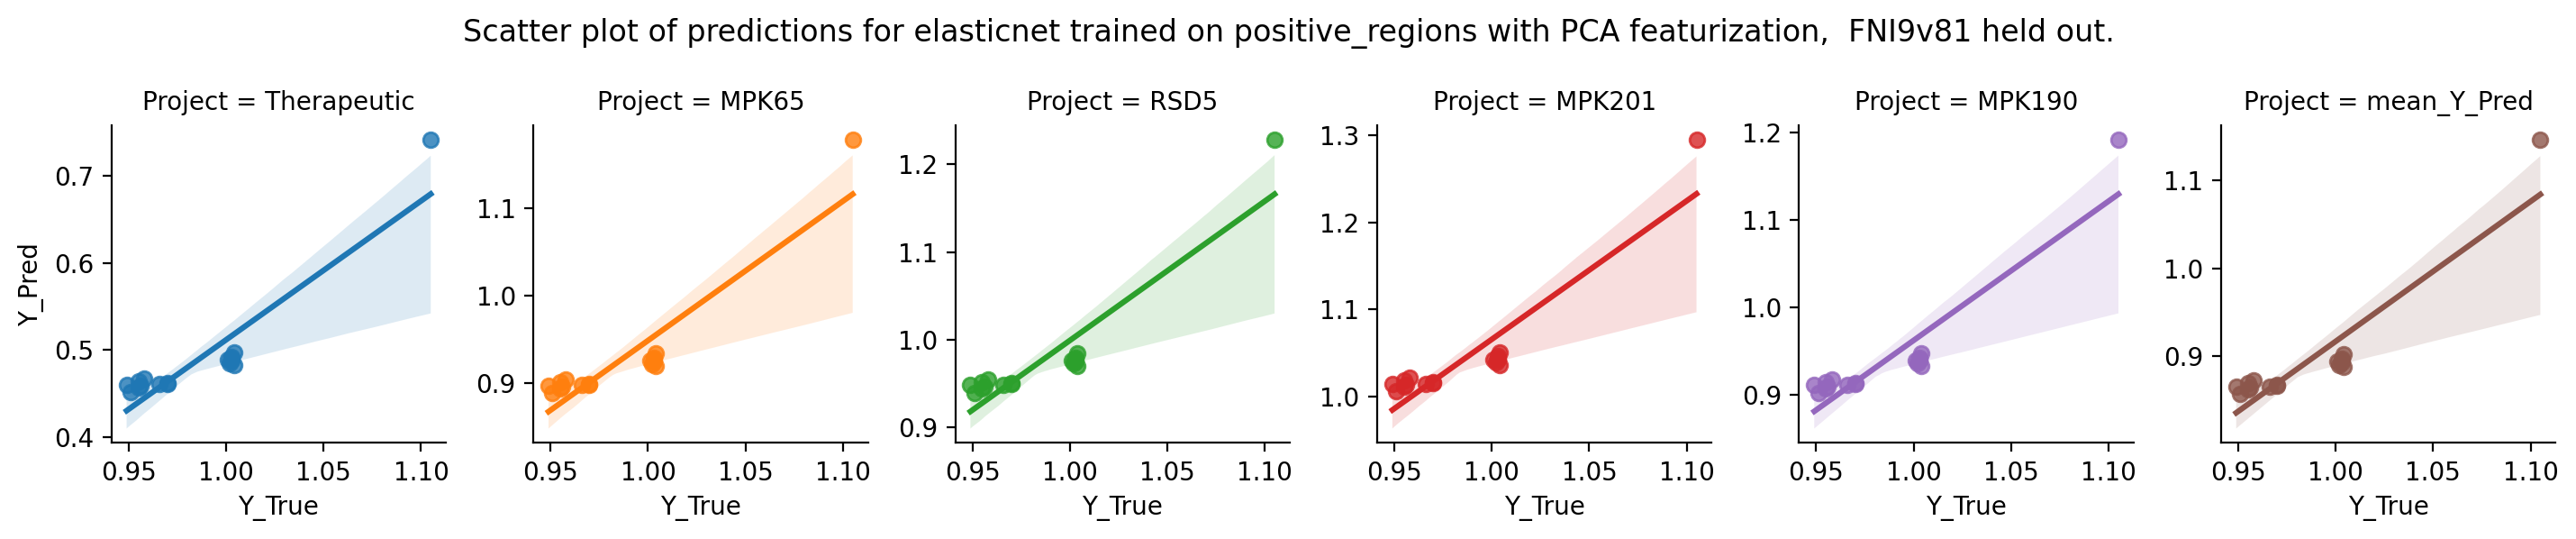

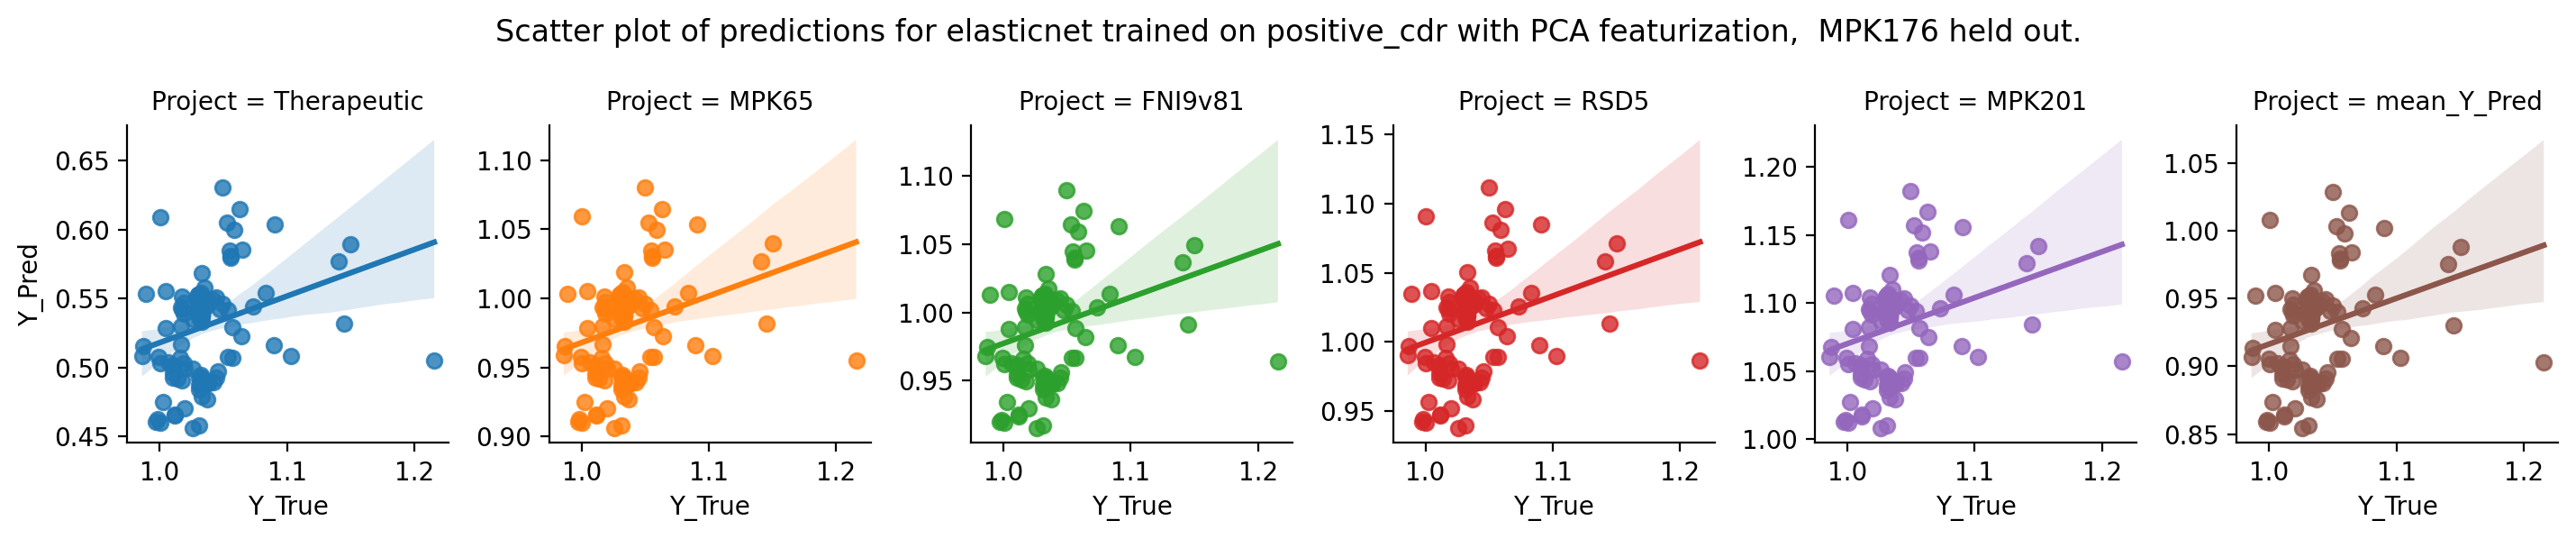

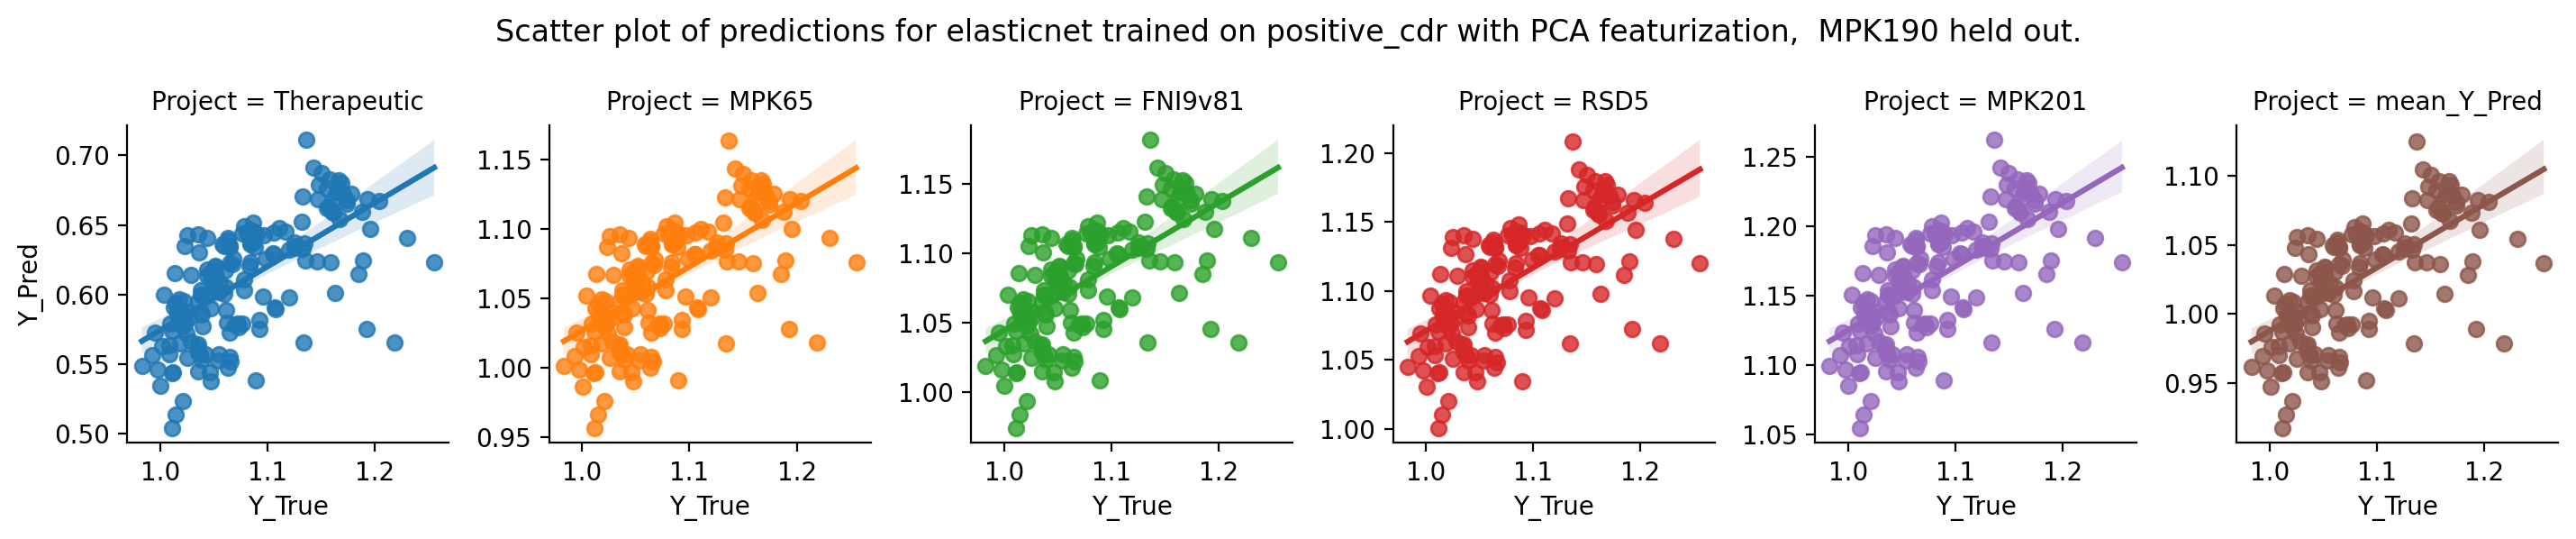

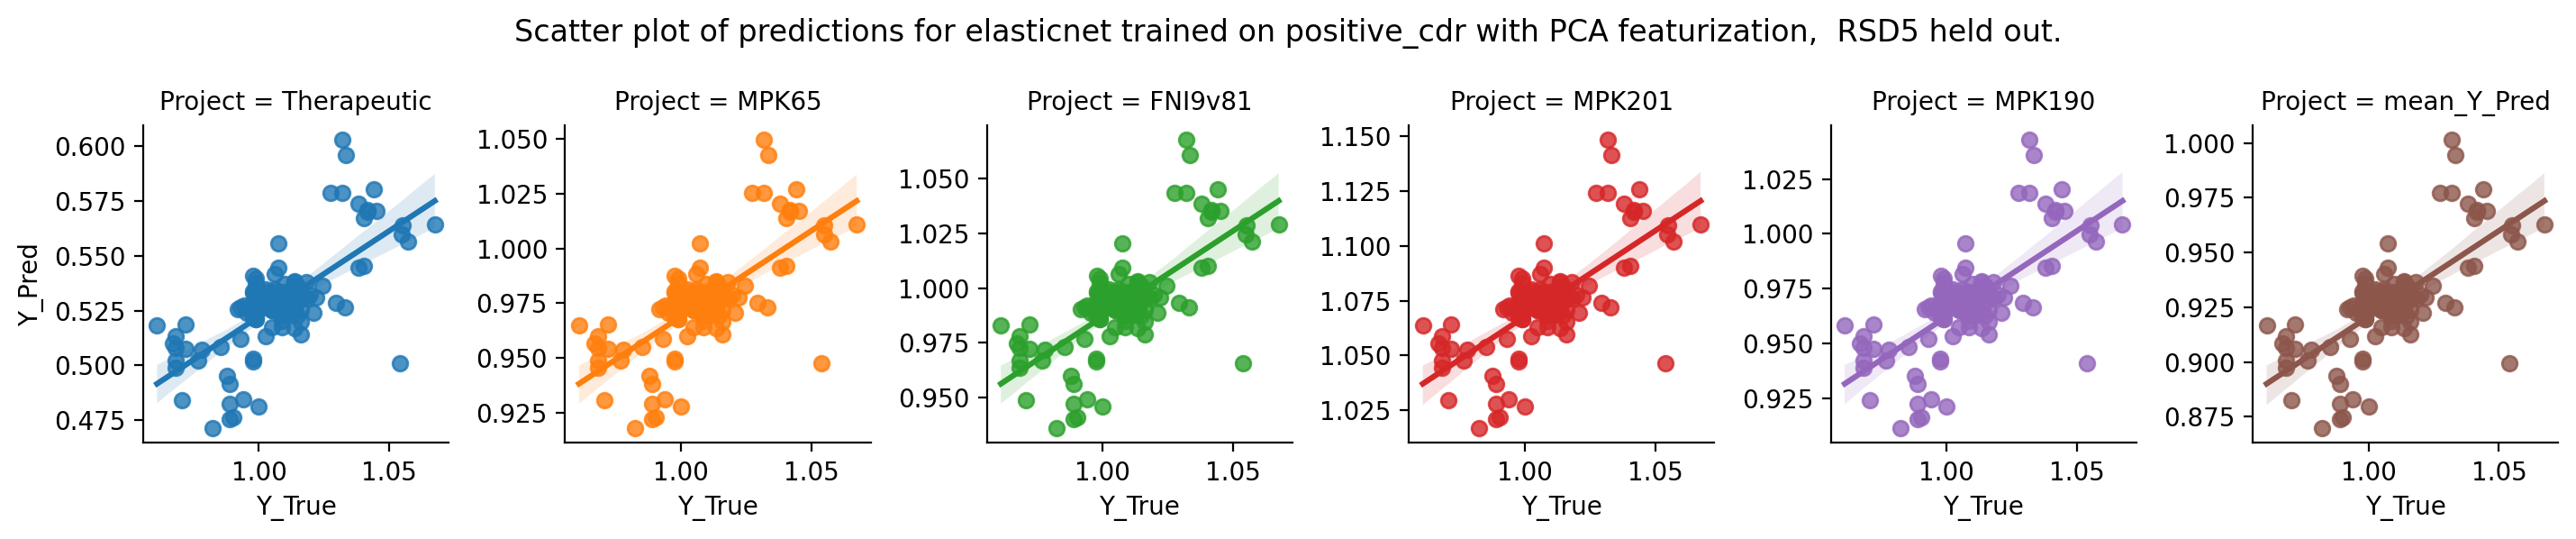

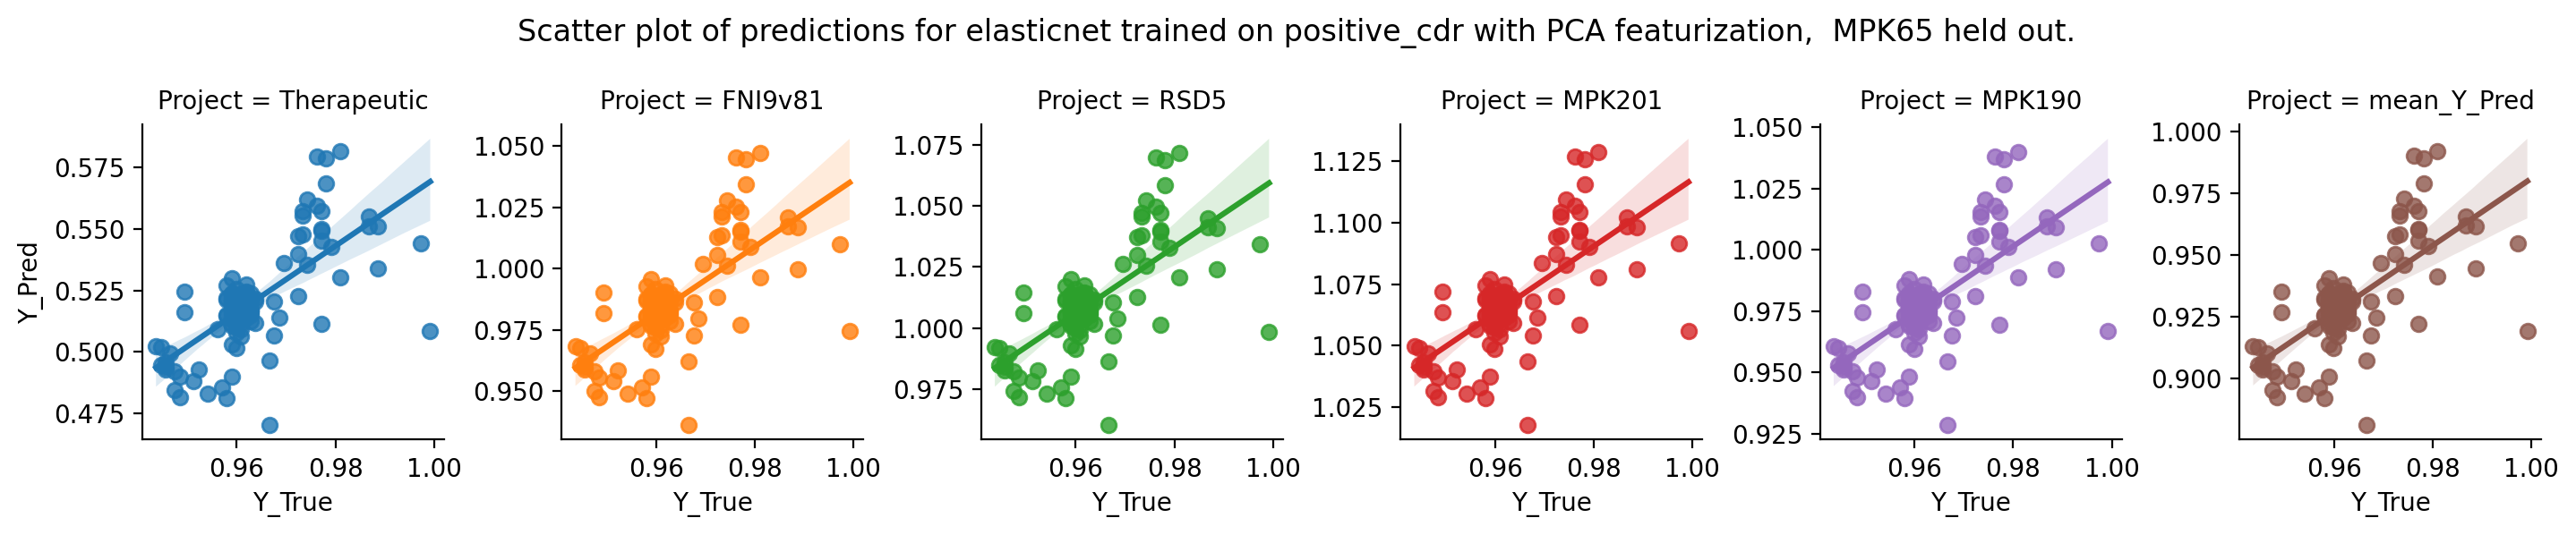

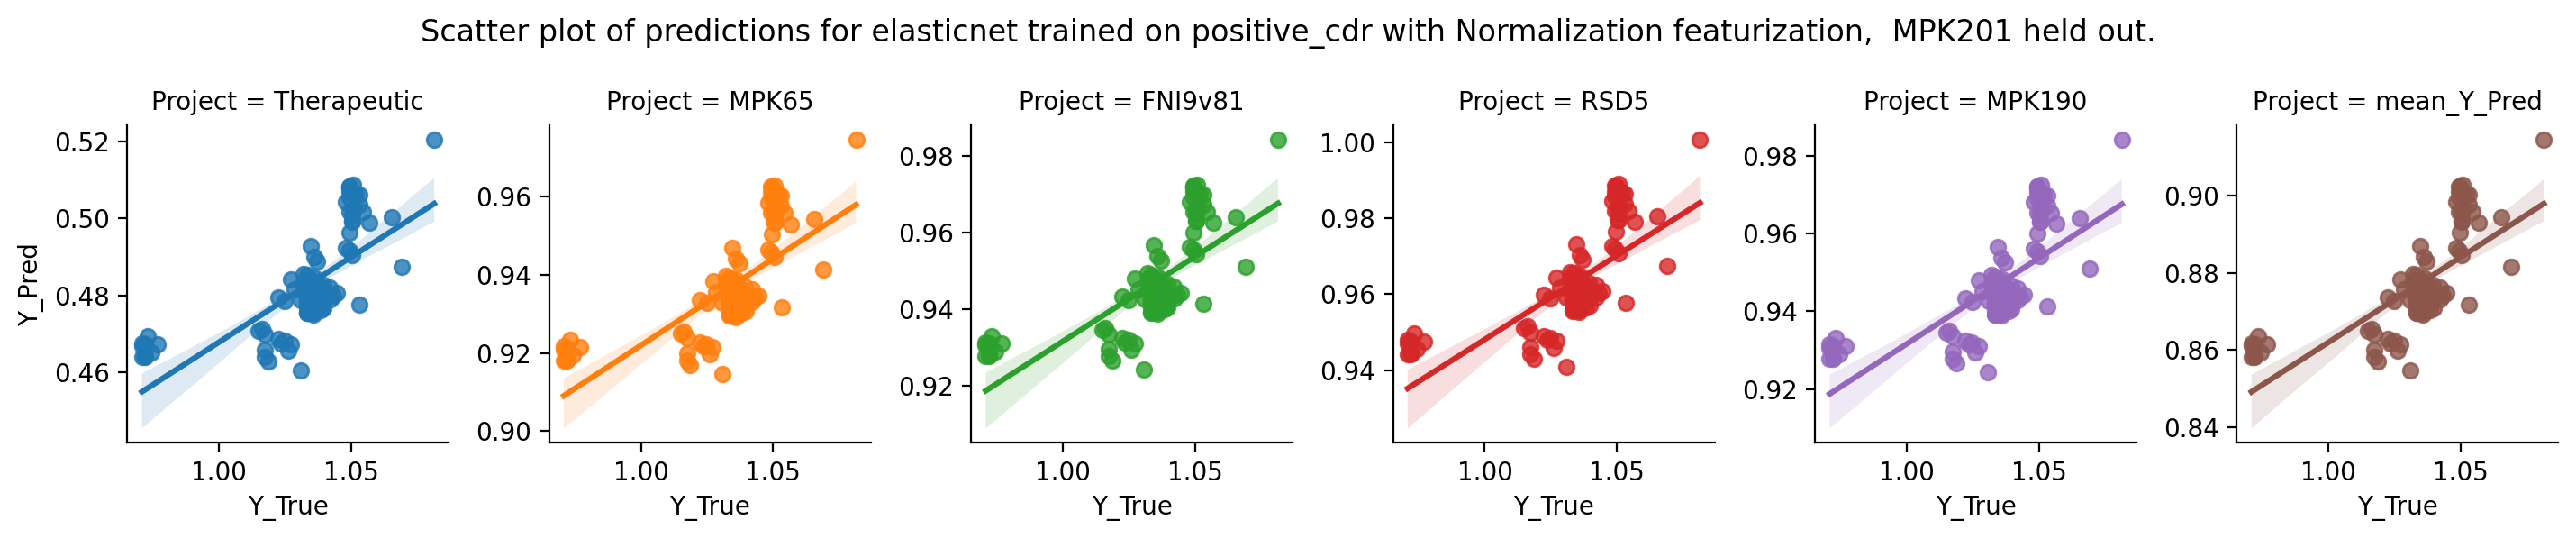

In [40]:
indices = best_model_by_project_no_rf['index'].values
for idx in indices: 
    plot_predictions(idx, aspect = 0.8)

In [41]:
n = 1
best_model_by_project_rf = (metadata2.query('model=="rf"')
                               .sort_values(['test_cv_rmse', 'test_cv_r2'], ascending = [True, False])
                               .groupby('Project')
                               .head(n)
                               .reset_index()
                               )
show(best_model_by_project_rf, index =True)

Therapeutic
FNI9v81
MPK176
RSD5
MPK190
MPK201
MPK65


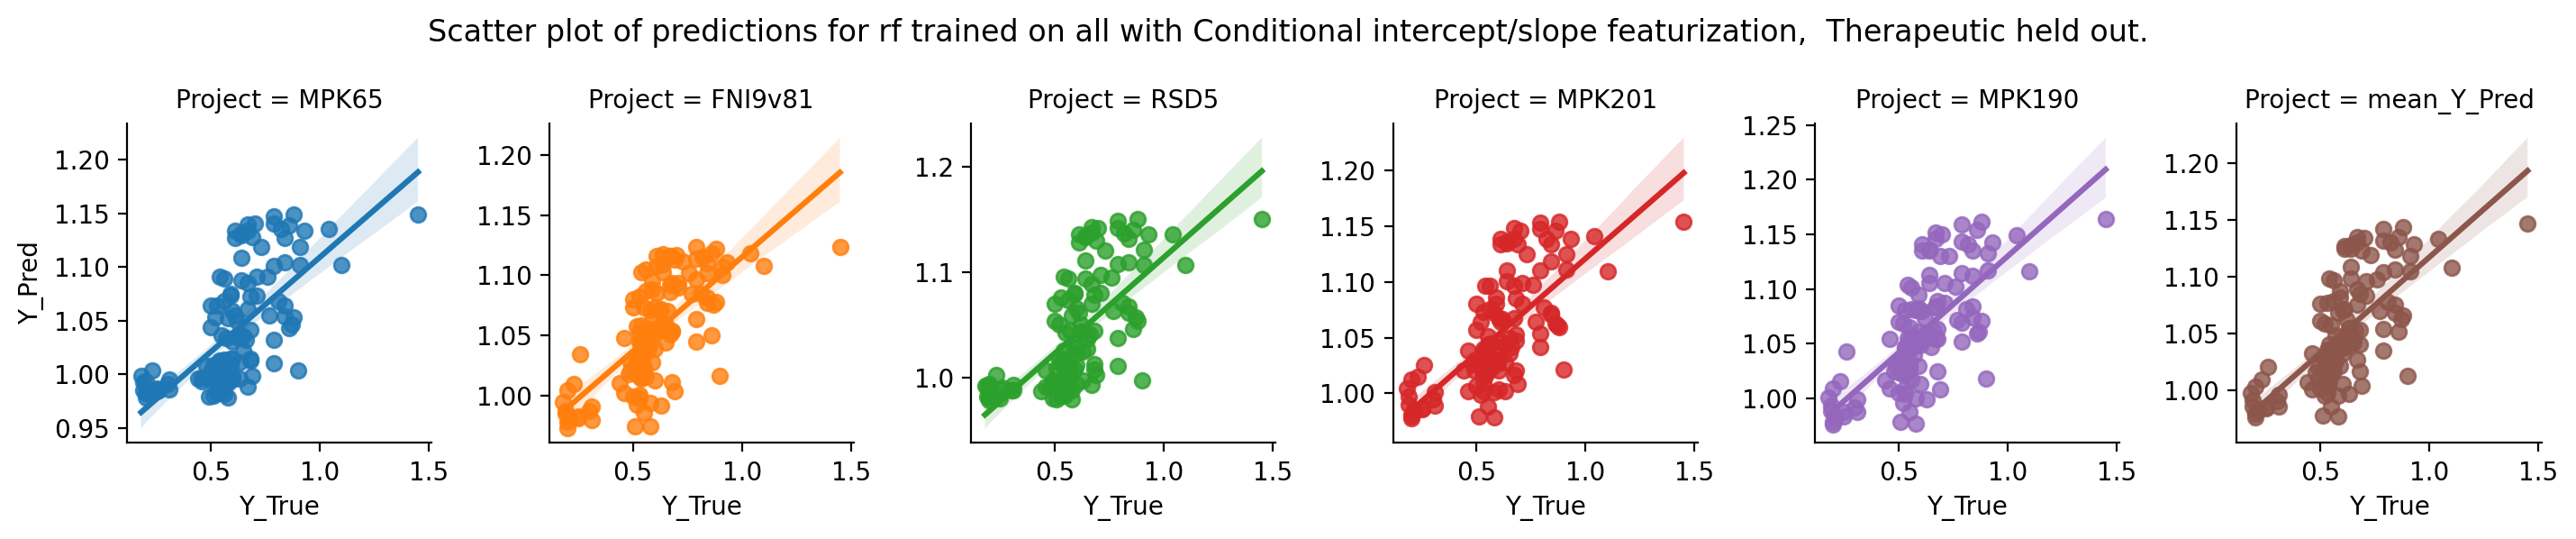

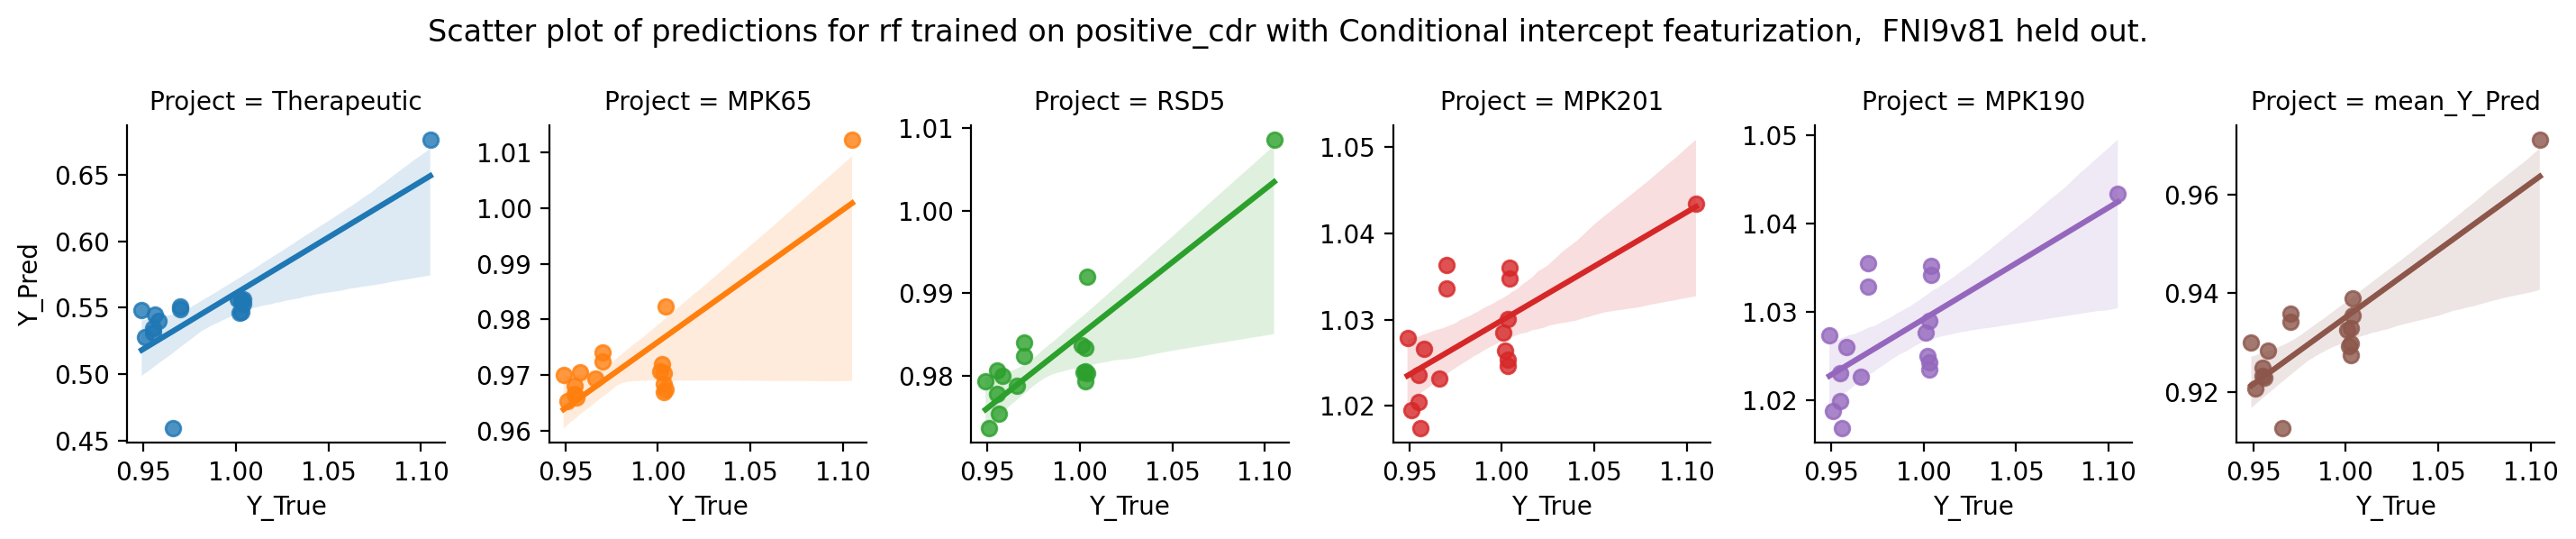

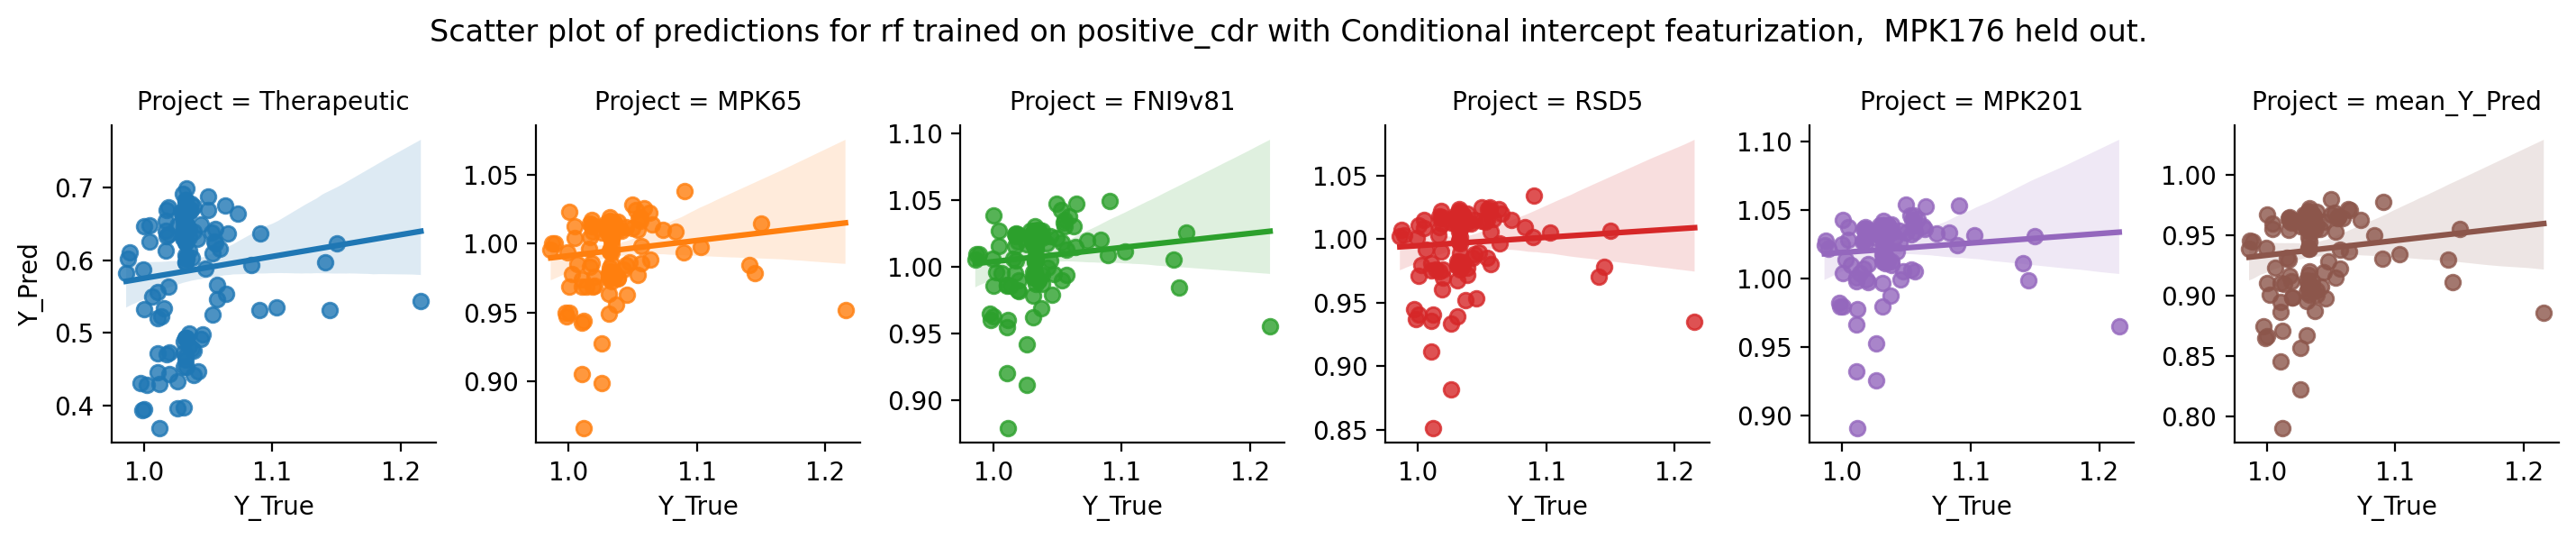

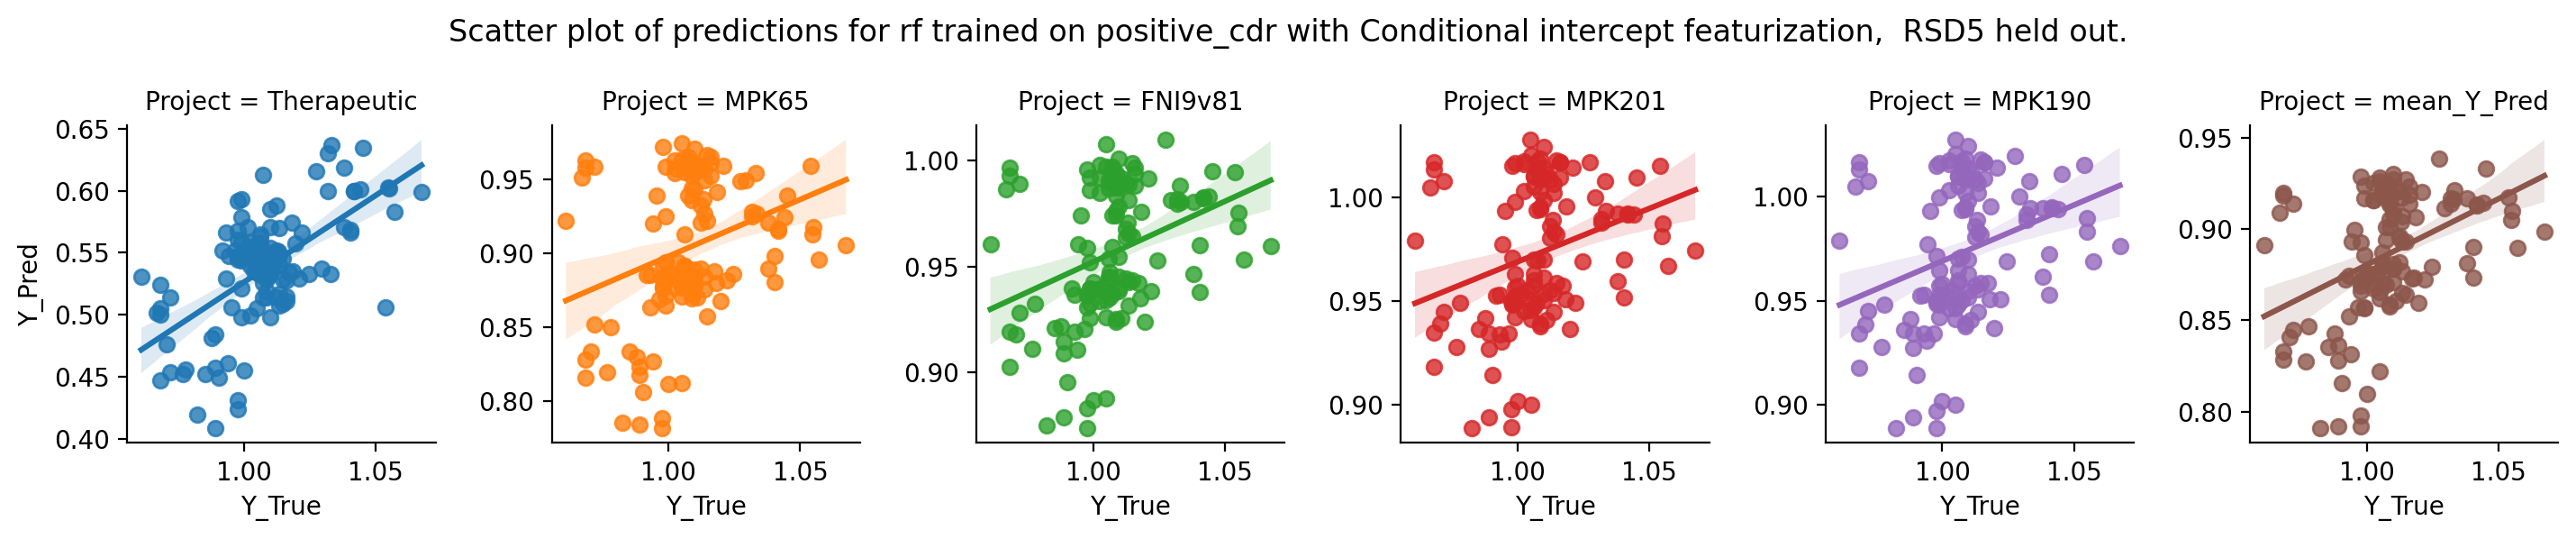

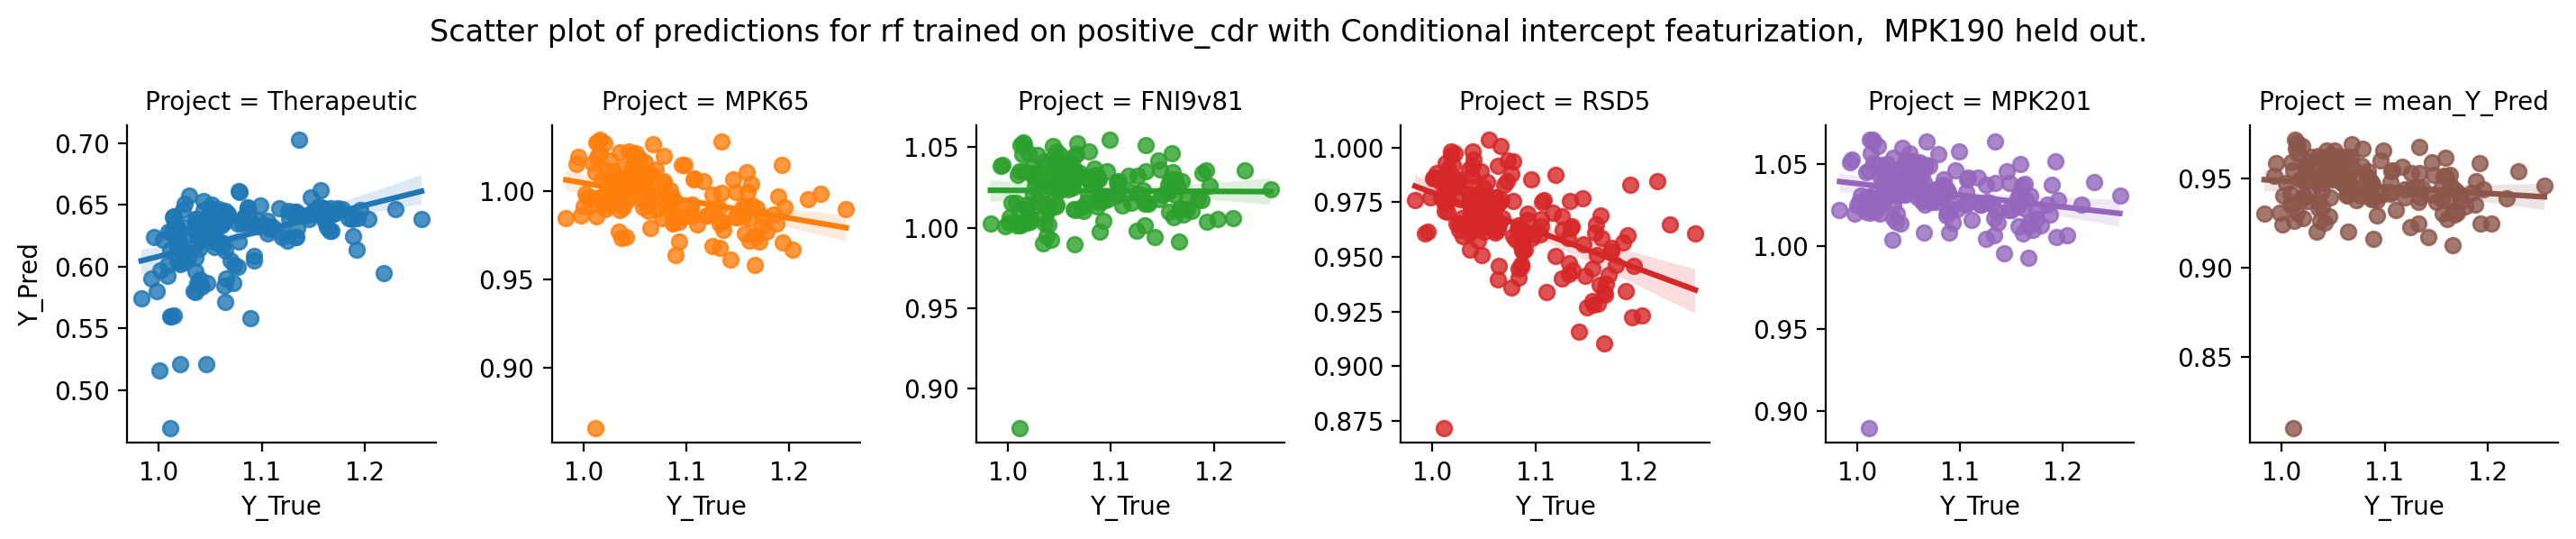

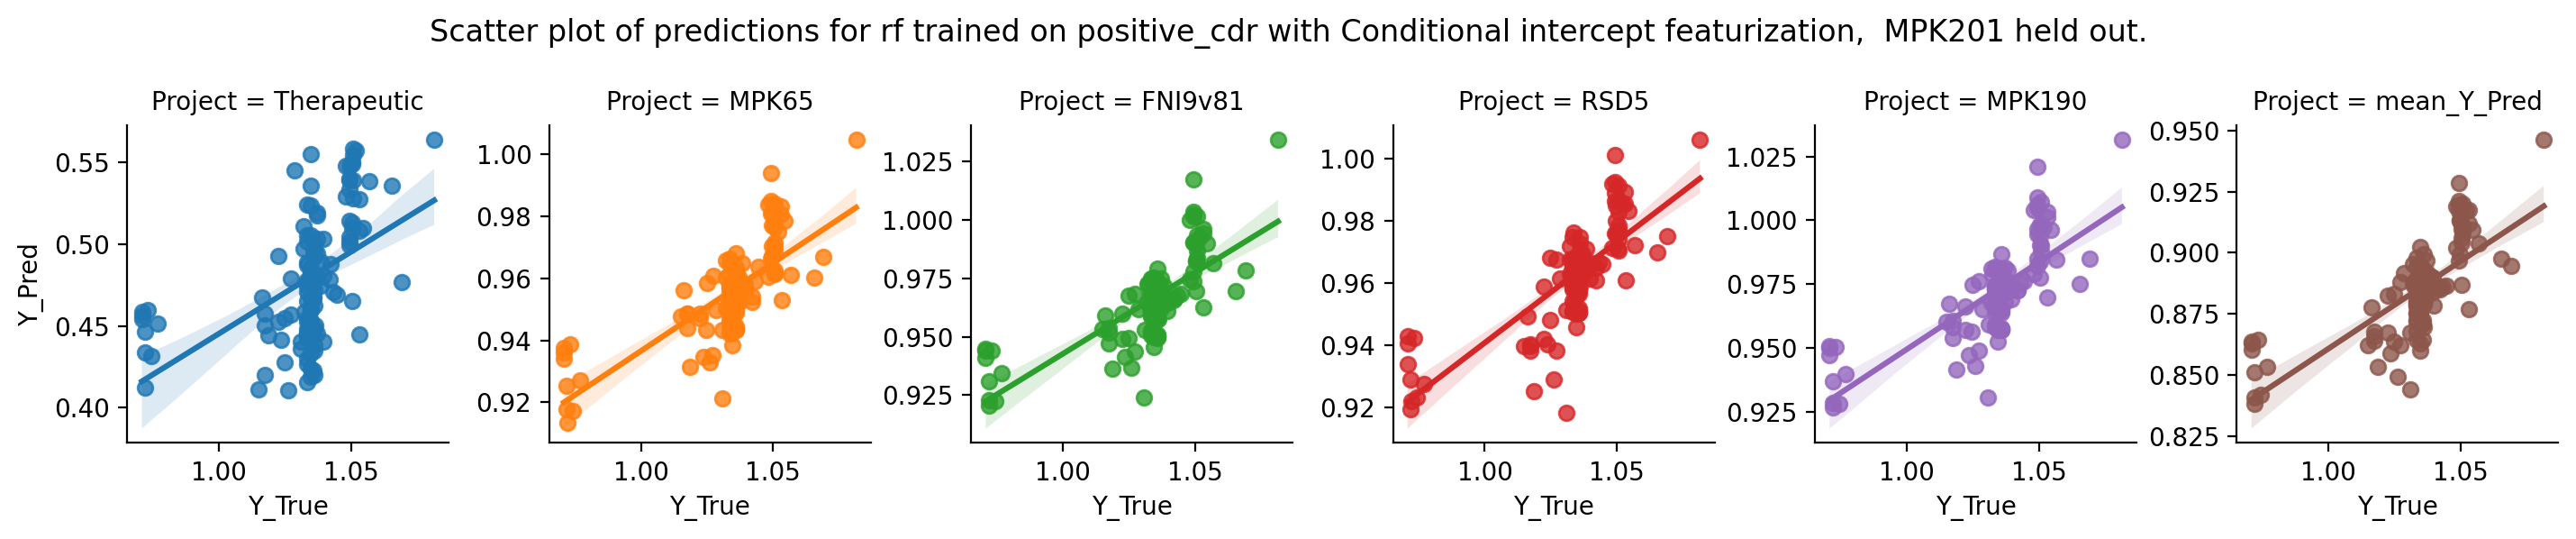

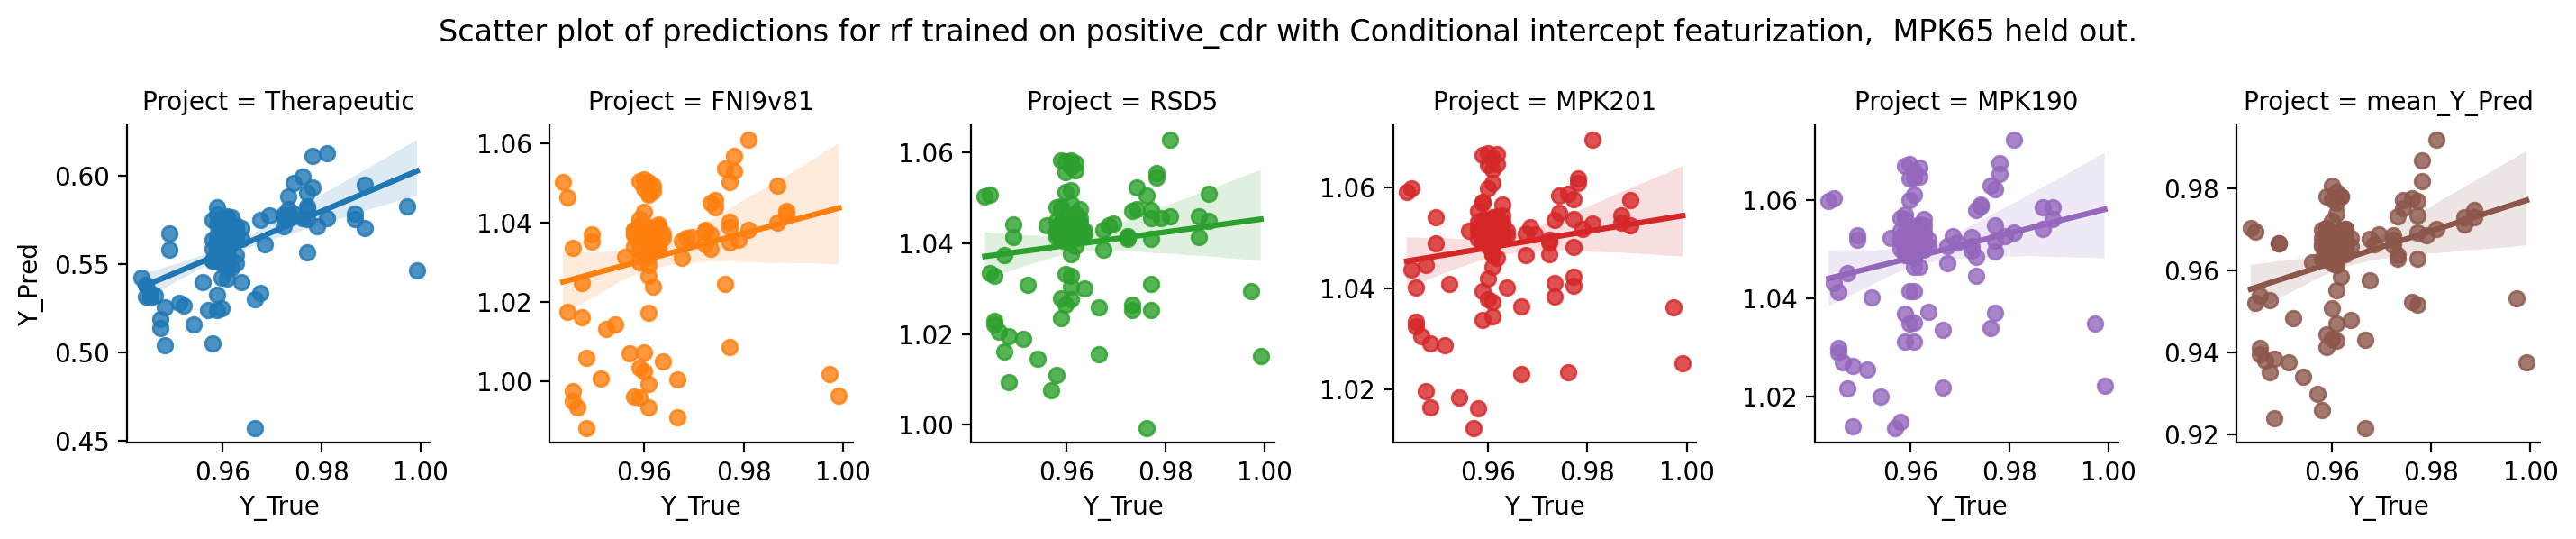

In [42]:
indices = best_model_by_project_rf['index'].values
for idx in indices: 
    plot_predictions(idx, aspect = 0.8)